In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import seaborn as sns
import matplotlib.pyplot as plt
import copy

from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_absolute_error
import math

import xgboost as xgb
from datetime import timedelta 
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import catboost as cb
import shap

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


/kaggle/input/rossmann-store-sales/sample_submission.csv
/kaggle/input/rossmann-store-sales/store.csv
/kaggle/input/rossmann-store-sales/train.csv
/kaggle/input/rossmann-store-sales/test.csv


In [2]:
store = pd.read_csv("/kaggle/input/rossmann-store-sales/store.csv")
train = pd.read_csv("/kaggle/input/rossmann-store-sales/train.csv")
test = pd.read_csv("/kaggle/input/rossmann-store-sales/test.csv")
submission = pd.read_csv("/kaggle/input/rossmann-store-sales/sample_submission.csv")

Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.


In [3]:
print(train.columns.tolist())
print(store.columns.tolist())
print(test.columns.tolist())

['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']


In [4]:
print(train.shape)
print(store.shape)

(1017209, 9)
(1115, 10)


In [5]:
train_v2 = pd.merge(train, store, left_on = 'Store', right_on = 'Store',how = 'left')
train_v2

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [6]:
train_v2.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [7]:
# mix data types in StateHoliday column
train_v2.StateHoliday = train_v2.StateHoliday.replace(0,'0')

In [8]:
train_v2.Promo2.unique()

array([0, 1])

In [9]:
train_v2.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [10]:
train_v2['PromoInterval'].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [11]:
train_v2.isna().sum()/train_v2.shape[0]*100

Store                         0.000000
DayOfWeek                     0.000000
Date                          0.000000
Sales                         0.000000
Customers                     0.000000
Open                          0.000000
Promo                         0.000000
StateHoliday                  0.000000
SchoolHoliday                 0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.259730
CompetitionOpenSinceMonth    31.787764
CompetitionOpenSinceYear     31.787764
Promo2                        0.000000
Promo2SinceWeek              49.943620
Promo2SinceYear              49.943620
PromoInterval                49.943620
dtype: float64

In [12]:
train_v2[(train_v2.CompetitionDistance.isna()==True)].isna().sum()

Store                           0
DayOfWeek                       0
Date                            0
Sales                           0
Customers                       0
Open                            0
Promo                           0
StateHoliday                    0
SchoolHoliday                   0
StoreType                       0
Assortment                      0
CompetitionDistance          2642
CompetitionOpenSinceMonth    2642
CompetitionOpenSinceYear     2642
Promo2                          0
Promo2SinceWeek              1884
Promo2SinceYear              1884
PromoInterval                1884
dtype: int64

In [13]:
train_v2[(train_v2.CompetitionOpenSinceMonth.isna()==True)].isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              138496
Promo2SinceYear              138496
PromoInterval                138496
dtype: int64

In [14]:
print(f"{train_v2[(train_v2.CompetitionOpenSinceMonth.isna()==True)&(train_v2.CompetitionDistance.isna()==False)].shape[0]/train_v2.shape[0]*100}% of stores are missing nearest competitors' opening time data")

31.528034061829967% of stores are missing nearest competitors' opening time data


- if CompetitionDistance is null, then CompetitionOpenSinceMonth, CompetitionOpenSinceYear must be null. means this store has no competition.
- if CompetitionOpenSinceMonth is null, then CompetitionSinceYear is null.
- if CompetitionOpenSinceMonth&CompetitionOpenSinceYear are null, but CompetitionDistance is not null, means missing records of opening time of the nearest competitors. nearly 32% stores are missing their nearest competitors' opening time data. need imputation. 

In [15]:
train_v2[(train_v2.Promo2==1)].isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance             758
CompetitionOpenSinceMonth    184852
CompetitionOpenSinceYear     184852
Promo2                            0
Promo2SinceWeek                   0
Promo2SinceYear                   0
PromoInterval                     0
dtype: int64

- Null values in Promo2SinceWeek, Promo2SinceYear, PromoInterval mean this store is not participating in Promo2. 

In [16]:
non_full_weeks_operate_stores = train_v2[(train_v2.DayOfWeek==7)&(train_v2.Open==0)].Store.unique().tolist()
full_weeks_operate_stores = train_v2[(train_v2.DayOfWeek==7)&(train_v2.Open==1)].Store.unique().tolist()

intersect = set(non_full_weeks_operate_stores).intersection(set(full_weeks_operate_stores))
non_full_week_operate_only = set(non_full_weeks_operate_stores).difference(intersect)
full_weeks_operate_only = set(full_weeks_operate_stores).difference(intersect)

print(intersect)
print(len(non_full_week_operate_only))
print(len(full_weeks_operate_only))
print(len(intersect))
print(train_v2[(train_v2.DayOfWeek==7)&(train_v2.Open==0)].Store.unique().shape[0])
print(train_v2[(train_v2.DayOfWeek==7)&(train_v2.Open==1)].Store.unique().shape[0])

{512, 259, 524, 530, 274, 1045, 931, 676, 299, 433, 948, 310, 1081, 578, 453, 1099, 209, 732, 863, 353, 867, 877, 122}
1082
10
23
1105
33


- 1105 stores close on DayOfWeek 7, 33 stores open DayofWeek 7, 23 stores sometimes closes on DayofWeek 7 sometimes open.
- 1082 stores only operate on non-7 day. 10 stores always operate full week.

In [17]:
train_v2[(train_v2.DayOfWeek==7)&(train_v2.Open == 1)&(train_v2.Store==931)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
6505,931,7,2015-07-26,3916,541,1,0,0,0,a,c,1480.0,9.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
14310,931,7,2015-07-19,3264,398,1,0,0,0,a,c,1480.0,9.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
22115,931,7,2015-07-12,2516,370,1,0,0,0,a,c,1480.0,9.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
29920,931,7,2015-07-05,2474,378,1,0,0,0,a,c,1480.0,9.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
37725,931,7,2015-06-28,2419,341,1,0,0,0,a,c,1480.0,9.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894375,931,7,2013-04-21,1066,173,1,0,0,0,a,c,1480.0,9.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
902180,931,7,2013-04-14,1241,190,1,0,0,0,a,c,1480.0,9.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
909985,931,7,2013-04-07,934,144,1,0,0,0,a,c,1480.0,9.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
917790,931,7,2013-03-31,1214,199,1,0,0,0,a,c,1480.0,9.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"


In [18]:
train_v2[(train_v2.Open==0)&(train_v2.StateHoliday=='0')&(train_v2.SchoolHoliday==0)&(train_v2.DayOfWeek!=7)].Store.unique()

array([ 292,  876,  909,  183,   70,  261,  286,  630,  971,  860,  772,
        293,  342,  674, 1018,  644,  383,  556, 1110,  525,  572,  755,
        563,  657,  731,   25,   30,   40,   74,   86,  216,  220,  238,
        256,  387,  418,  425,  445,  470,  475,  508,  586,  758,  776,
        826,  845,  847,  861,  885,  891,  913,  916,  956,  984, 1025,
       1047,   22,  699, 1021,  336,  708,  357,  848,  227,  123,  835,
         28,  950,  169,  303,  870,  972,  887,  102,  882,   57,  925,
        264, 1017, 1055, 1100,  922,   20,  661,  492,  502,  850,  145,
       1051,  376,  986,  327,  184,  947,  837,  390,  962,  623,  760,
        983,  663,  996,  744,  391,  603,  308,  927,  348,  100,  106,
       1039,  103, 1081,  665,  894,  638,  715,  444,  700,    5,  897,
        364,  681,  589,  118,  105,  948,  349,  764,  676,  353,  969,
        274,  560,   90,  557,  259,  517,  339,  404,  232,  762,  512])

- Many stores will close for refurbishment for multiple dates. and the dates are random

In [19]:
train_v2[(train_v2.Open==0)&(train_v2.StateHoliday=='0')&(train_v2.SchoolHoliday==0)&(train_v2.DayOfWeek!=7)&(train_v2.Store==776)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
184750,776,1,2015-02-16,0,0,0,1,0,0,c,a,700.0,4.0,2009.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
541880,776,1,2014-03-03,0,0,0,1,0,0,c,a,700.0,4.0,2009.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
971155,776,1,2013-02-11,0,0,0,0,0,0,c,a,700.0,4.0,2009.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [20]:
# check the weekly patterns of sales for 1115 stores seperately
train_v2[train_v2.Store == 122].groupby('DayOfWeek')['Sales'].mean()

DayOfWeek
1    7830.037313
2    6674.333333
3    6672.562963
4    6205.925926
5    6516.444444
6    6605.141791
7    1979.238806
Name: Sales, dtype: float64

- There is a weekly pattern in terms of sales. Sales peak on DayOfWeek 1,2, the gradually go down on 3,4,5,6. Most stores close at 7

In [21]:
train_v2[(train_v2.DayOfWeek==7)&(train_v2.Open==1)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
5659,85,7,2015-07-26,11421,1606,1,0,0,0,b,a,1870.0,10.0,2011.0,0,NaN,NaN,NaN
5696,122,7,2015-07-26,5773,707,1,0,0,0,a,c,58260.0,4.0,2013.0,0,NaN,NaN,NaN
5783,209,7,2015-07-26,3742,354,1,0,0,0,a,c,11680.0,9.0,2011.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
5833,259,7,2015-07-26,15998,2857,1,0,0,0,b,b,210.0,NaN,NaN,0,NaN,NaN,NaN
5836,262,7,2015-07-26,32547,4783,1,0,0,0,b,a,1180.0,5.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011252,733,7,2013-01-06,11226,2584,1,0,0,0,b,b,860.0,10.0,1999.0,0,NaN,NaN,NaN
1011288,769,7,2013-01-06,6995,1764,1,0,0,0,b,b,840.0,NaN,NaN,1,48.0,2012.0,"Jan,Apr,Jul,Oct"
1011382,863,7,2013-01-06,2067,255,1,0,0,0,a,c,21370.0,11.0,2010.0,0,NaN,NaN,NaN
1011467,948,7,2013-01-06,6024,1402,1,0,a,0,b,b,1430.0,NaN,NaN,0,NaN,NaN,NaN


In [22]:
train_v2[(train_v2['Store']==11)&(train_v2['DayOfWeek']==7)].Open.unique()

array([0])

In [23]:
df = train_v2[train_v2['Store']==11].groupby('DayOfWeek')['Sales'].mean().to_frame()
max_sales = max(df.Sales)
max_sales_index = df[df.Sales==max_sales].index
max_sales_index

Index([1], dtype='int64', name='DayOfWeek')

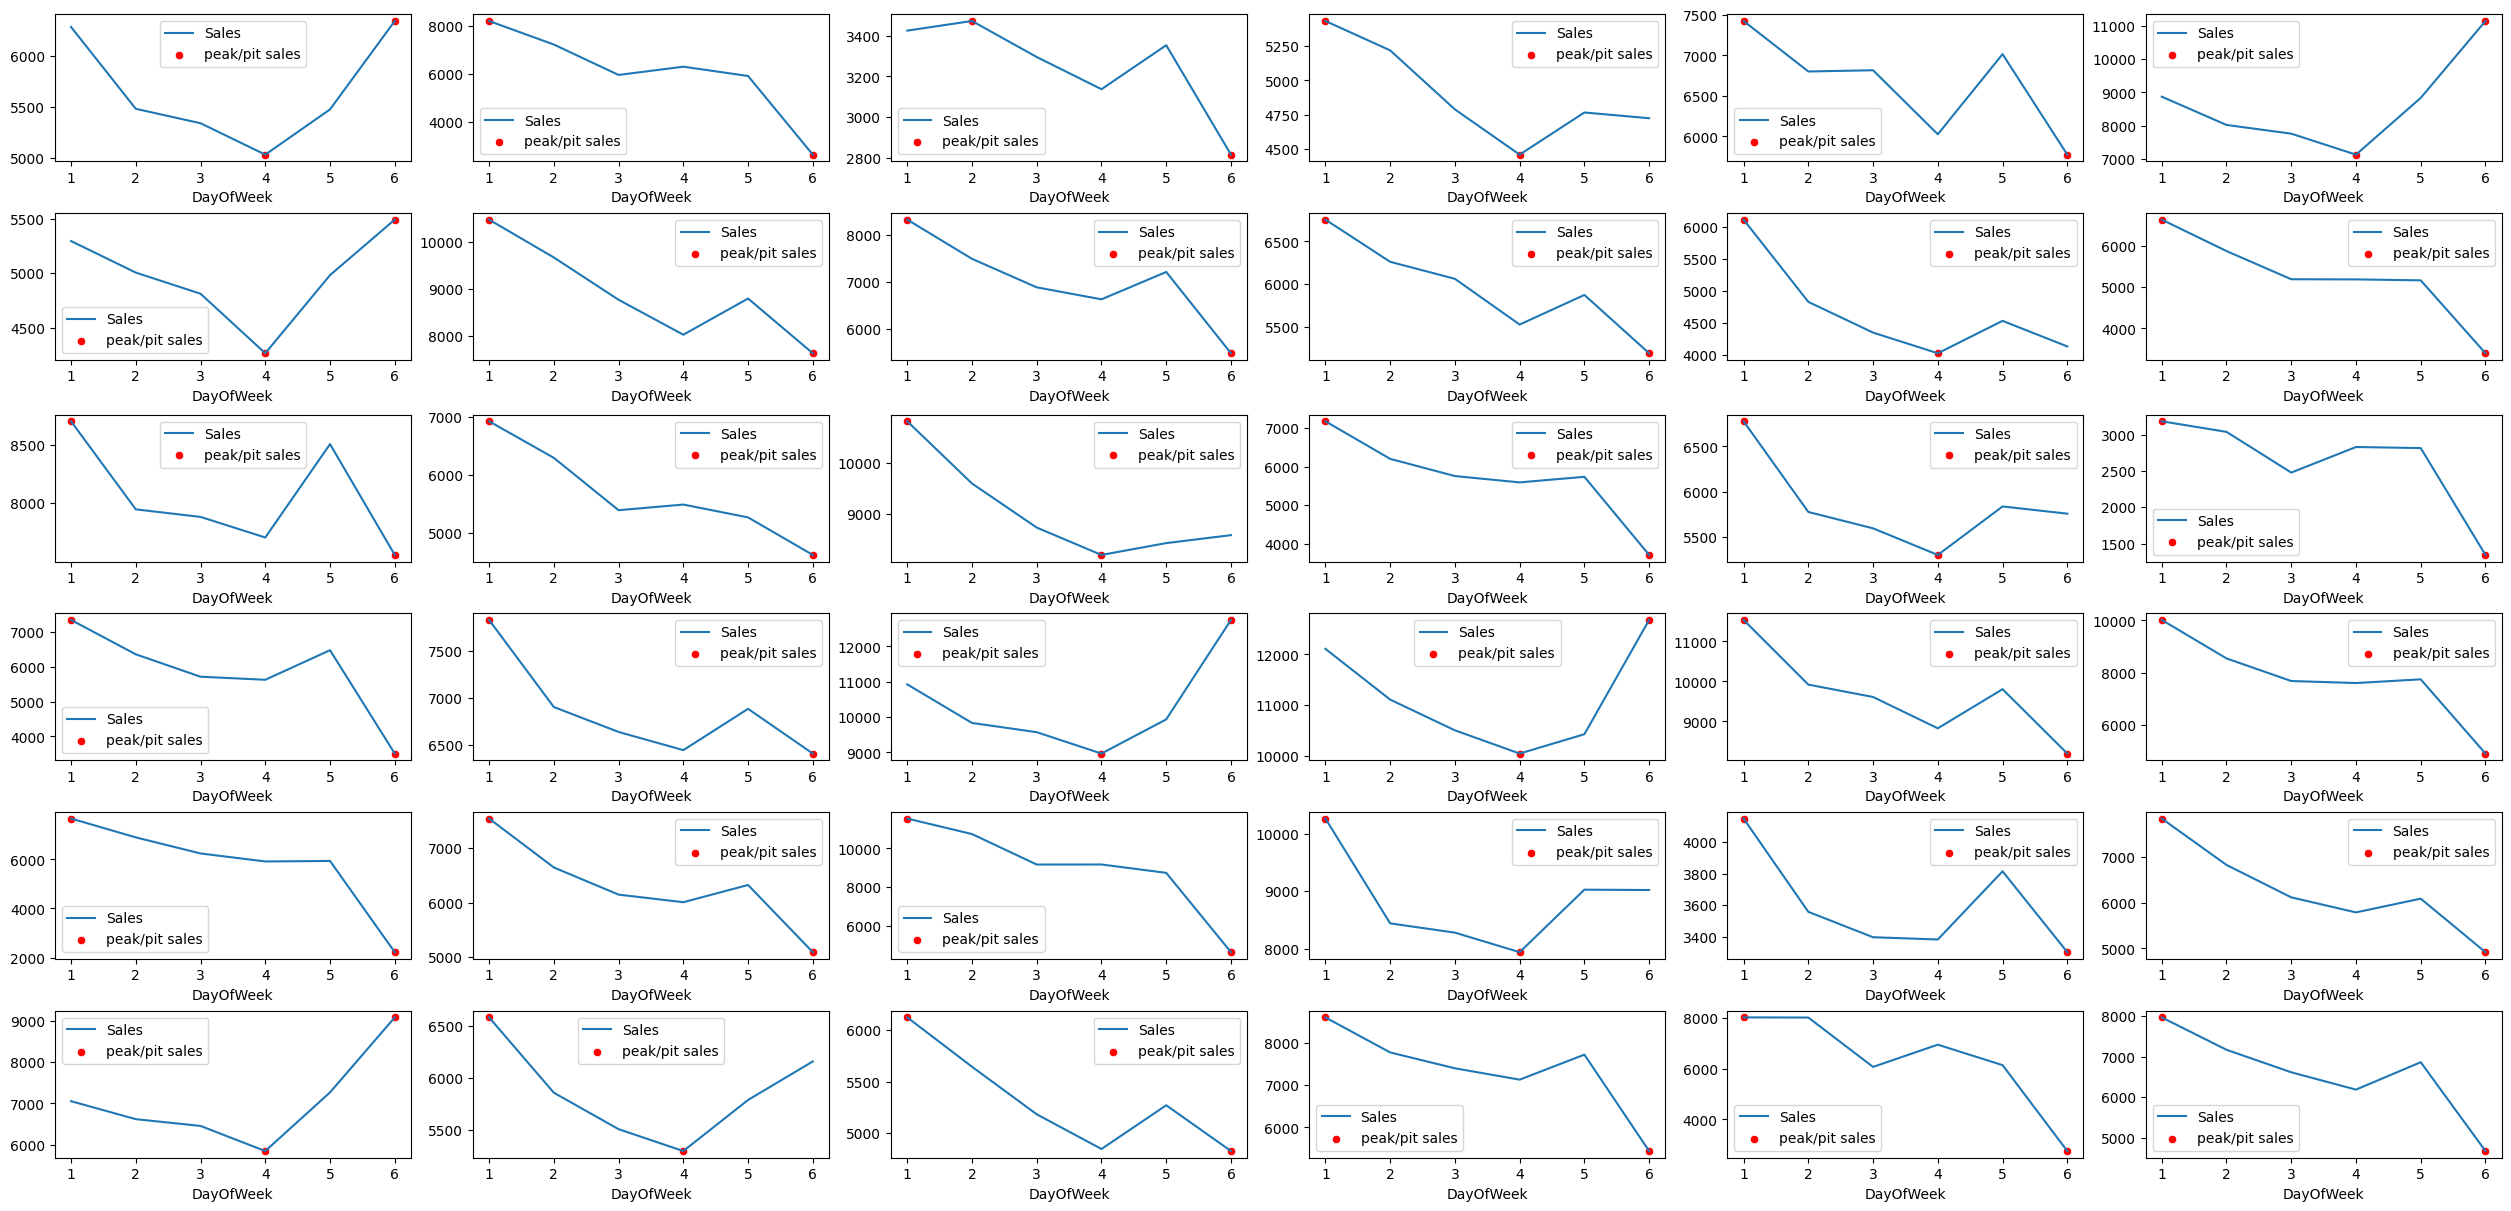

In [24]:
fig, axes = plt.subplots(6,6,figsize = (25,12), constrained_layout = True)
axes = axes.flatten()
num_stores = 36
non_full_week_sample = random.sample(list(non_full_week_operate_only),num_stores)

for index in range(num_stores):
    store = non_full_week_sample[index]
    df = train_v2[(train_v2['Store']==store)&(train_v2['DayOfWeek']!=7)].groupby('DayOfWeek')['Sales'].mean().to_frame()
    sns.lineplot(df, ax = axes[index])
    axes[index].set_xticks(df.index)
    
    max_sales = max(df.Sales)
    min_sales = min(df.Sales)
    max_sales_index = df[df.Sales==max_sales].index[0]
    min_sales_index = df[df.Sales==min_sales].index[0]
    
    sns.scatterplot(x=[min_sales_index,max_sales_index],y=[min_sales,max_sales], color = 'red',marker='o', label = 'peak/pit sales', ax = axes[index])
    
    
plt.show()

- weekly sales pattern: for shops operate for 6 days a week(close on Sundays), the sales drop from monday to saturday. These stores might highly rely on students. 

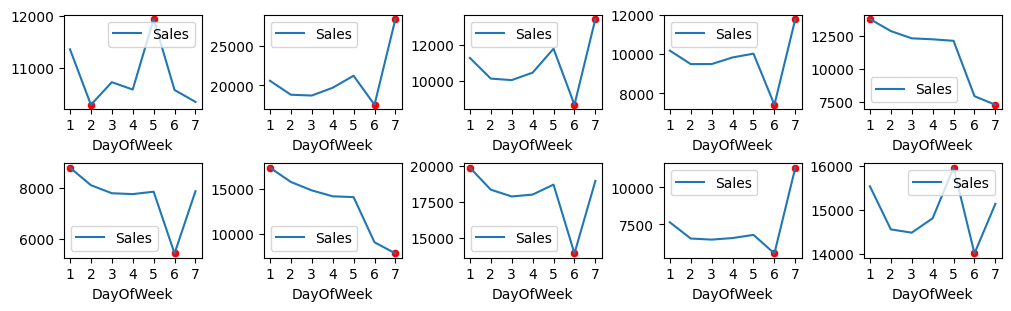

In [50]:
fig, axes = plt.subplots(2,5,figsize = (10,3), constrained_layout = True)
axes = axes.flatten()
num_stores = 10

for index in range(num_stores):
    store = list(full_weeks_operate_only)[index]
    df = train_v2[train_v2['Store']==store].groupby('DayOfWeek')['Sales'].mean().to_frame()
    sns.lineplot(df, ax = axes[index])
    axes[index].set_xticks(df.index)
    
    max_sales = max(df.Sales)
    min_sales = min(df.Sales)
    max_sales_index = df[df.Sales==max_sales].index[0]
    min_sales_index = df[df.Sales==min_sales].index[0]
    
    sns.scatterplot(x=[min_sales_index,max_sales_index],y=[min_sales,max_sales], color = 'red',marker='o', ax = axes[index])
    
    
plt.show()

- for shops operate for 7 days a week, 4 of them has peak in sales on Sunday. 9 of them has pit sales on weekends. These stores might rely on sales from schools.

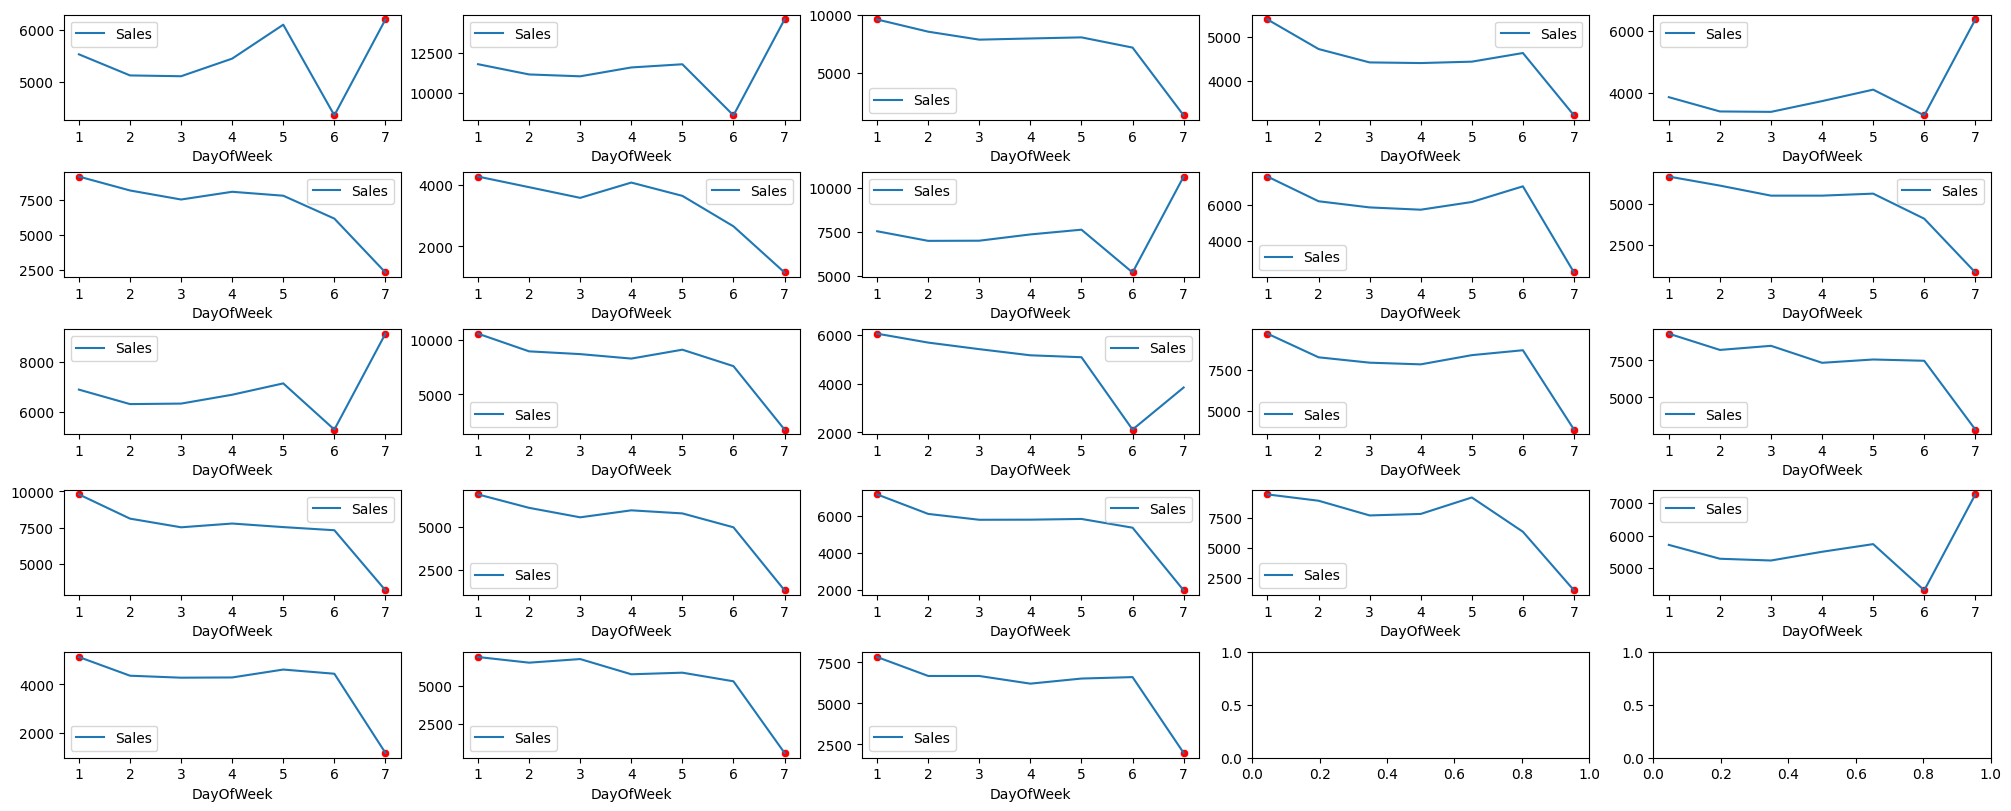

In [51]:
fig, axes = plt.subplots(5,5,figsize = (20,8), constrained_layout = True)
axes = axes.flatten()
num_stores = 23

for index in range(num_stores):
    store = list(intersect)[index]
    df = train_v2[train_v2['Store']==store].groupby('DayOfWeek')['Sales'].mean().to_frame()
    sns.lineplot(df, ax = axes[index])
    axes[index].set_xticks(df.index)
    
    max_sales = max(df.Sales)
    min_sales = min(df.Sales)
    max_sales_index = df[df.Sales==max_sales].index[0]
    min_sales_index = df[df.Sales==min_sales].index[0]
    
    sns.scatterplot(x=[min_sales_index,max_sales_index],y=[min_sales,max_sales], color = 'red',marker='o', ax = axes[index])    
    
plt.show()

In [25]:
train_v2['Date'] = pd.to_datetime(train_v2.Date)
train_v2['Year'] = train_v2.Date.apply(lambda x:x.year)
train_v2['Month'] = train_v2.Date.apply(lambda x:x.month)
train_v2['Quarter'] = train_v2.Date.apply(lambda x:x.quarter)
train_v2['WeekOfYear'] = train_v2.Date.apply(lambda x:x.week)
train_v2

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Quarter,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015,7,3,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,3,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,3,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,9.0,2009.0,0,NaN,NaN,NaN,2015,7,3,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,4.0,2015.0,0,NaN,NaN,NaN,2015,7,3,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,...,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,...,4.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,...,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,...,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1


In [26]:
train_v2['PromoInterval'].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [27]:
train_v2['PromoInterval_v2'] = train_v2['PromoInterval'].str.split(',')

In [28]:
train_v2.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Quarter',
       'WeekOfYear', 'PromoInterval_v2'],
      dtype='object')

In [29]:
train_v2[['Month','Promo2','Promo2SinceWeek','Promo2SinceYear','PromoInterval_v2']]

,Month,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval_v2
0,7,0,NaN,NaN,NaN
1,7,1,13.0,2010.0,"[Jan, Apr, Jul, Oct]"
2,7,1,14.0,2011.0,"[Jan, Apr, Jul, Oct]"
3,7,0,NaN,NaN,NaN
4,7,0,NaN,NaN,NaN
...,...,...,...,...,...
1017204,1,1,31.0,2013.0,"[Jan, Apr, Jul, Oct]"
1017205,1,0,NaN,NaN,NaN
1017206,1,0,NaN,NaN,NaN
1017207,1,0,NaN,NaN,NaN


In [30]:
month_char_to_num = {'Jan':1,
                    'Feb':2,
                    'Mar':3,
                    'Apr':4,
                    'May':5,
                    'Jun':6,
                    'Jul':7,
                    'Aug':8,
                    'Sept':9,
                    'Oct':10,
                    'Nov':11,
                    'Dec':12}

def month_char_to_num_func(month_list):
    if type(month_list)==list:
        for idx in range(len(month_list)):
            month = month_list[idx]
            month_num = month_char_to_num[month]
            month_list[idx] = month_num
    else:
        month_list = []
        
    return month_list

train_v2["PromoInterval_v2"] = train_v2["PromoInterval_v2"].apply(lambda x:month_char_to_num_func(x))

In [31]:
# axis=1 specify that the function should be applied row-wise
train_v2['PromoJustStarted'] = train_v2.apply(lambda row: 1 if row['Month'] in row['PromoInterval_v2'] else 0, axis=1)

In [32]:
train_v2.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Quarter,WeekOfYear,PromoInterval_v2,PromoJustStarted
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,0,NaN,NaN,NaN,2015,7,3,31,[],0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,3,31,"[1, 4, 7, 10]",1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,3,31,"[1, 4, 7, 10]",1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,0,NaN,NaN,NaN,2015,7,3,31,[],0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,0,NaN,NaN,NaN,2015,7,3,31,[],0


In [33]:
train_v2.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Quarter',
       'WeekOfYear', 'PromoInterval_v2', 'PromoJustStarted'],
      dtype='object')

In [34]:
train_v2.Store = train_v2.Store.astype('object')
train_v2.DayOfWeek = train_v2.DayOfWeek.astype('object')
train_v2.SchoolHoliday = train_v2.SchoolHoliday.astype('object')
train_v2.Promo2 = train_v2.Promo2.astype('object')
train_v2.Open = train_v2.Open.astype('object')
train_v2.Promo = train_v2.Promo.astype('object')

train_v2.Year = train_v2.Year.astype('int64')
train_v2.Month = train_v2.Month.astype('int64')
train_v2.Quarter = train_v2.Quarter.astype('int64')
train_v2.WeekOfYear = train_v2.WeekOfYear.astype('int64')
train_v2.PromoJustStarted = train_v2.PromoJustStarted.astype('object')

In [35]:
train_v2['NumOfYearSinceCompetitionOpen'] = train_v2['Year']-train_v2['CompetitionOpenSinceYear']
train_v2['NumOfYearSincePromo2'] = train_v2['Year']-train_v2['Promo2SinceYear']

In [36]:
train_v2.dtypes

Store                                    object
DayOfWeek                                object
Date                             datetime64[ns]
Sales                                     int64
Customers                                 int64
Open                                     object
Promo                                    object
StateHoliday                             object
SchoolHoliday                            object
StoreType                                object
Assortment                               object
CompetitionDistance                     float64
CompetitionOpenSinceMonth               float64
CompetitionOpenSinceYear                float64
Promo2                                   object
Promo2SinceWeek                         float64
Promo2SinceYear                         float64
PromoInterval                            object
Year                                      int64
Month                                     int64
Quarter                                 

In [37]:
train_v2['NumOfYearSincePromo2'].unique()

array([nan,  5.,  4.,  3.,  6.,  1.,  0.,  2., -1., -2.])

In [38]:
numerical_features = train_v2.select_dtypes(include = np.number).columns.tolist()
numerical_features.remove('Sales')
categorical_features = train_v2.select_dtypes(include = 'object').columns.tolist()
categorical_features.remove('Store')
categorical_features.remove('PromoInterval')
categorical_features.remove('PromoInterval_v2')
print(numerical_features)
print(categorical_features)

['Customers', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Quarter', 'WeekOfYear', 'NumOfYearSinceCompetitionOpen', 'NumOfYearSincePromo2']
['DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'Promo2', 'PromoJustStarted']


In [39]:
corr = train_v2.loc[:,numerical_features].corrwith(train_v2['Sales']).to_frame()
corr['abs corr'] = corr[0].abs()
corr.rename(columns = {0:'corr'}, inplace = True)
sorted_corr = corr.sort_values('abs corr', ascending = False)
sorted_corr

,corr,abs corr
Customers,0.894711,0.894711
Promo2SinceWeek,0.059558,0.059558
WeekOfYear,0.052946,0.052946
Month,0.048768,0.048768
Quarter,0.043984,0.043984
NumOfYearSincePromo2,0.031143,0.031143
CompetitionOpenSinceMonth,-0.028257,0.028257
Year,0.023519,0.023519
Promo2SinceYear,-0.021127,0.021127
CompetitionDistance,-0.019229,0.019229


- only 'Customers' is highly correlated with Sales. other variables are not meaningfully correlated with Sales

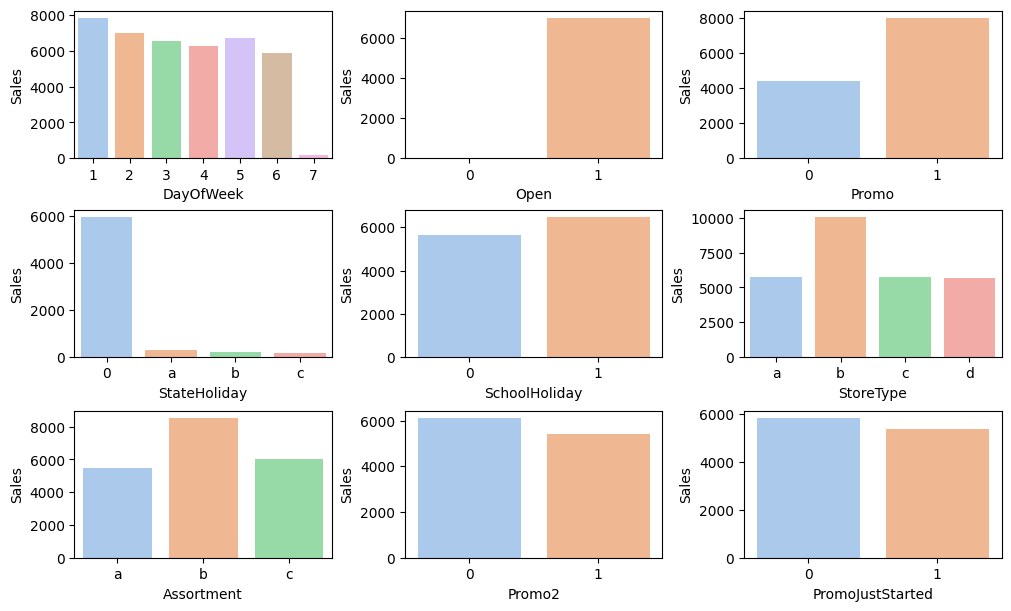

In [43]:
sns.set_palette('pastel')
fig, axes = plt.subplots(3,3,figsize = (10,6), constrained_layout = True)
axes = axes.flatten()
count = len(categorical_features)
for idx in range(count):
    feature = categorical_features[idx]
    df = train_v2.groupby(feature).Sales.mean().to_frame().reset_index()
    sns.barplot(data = df, x = df.columns[0], y = df.columns[1],ax = axes[idx])

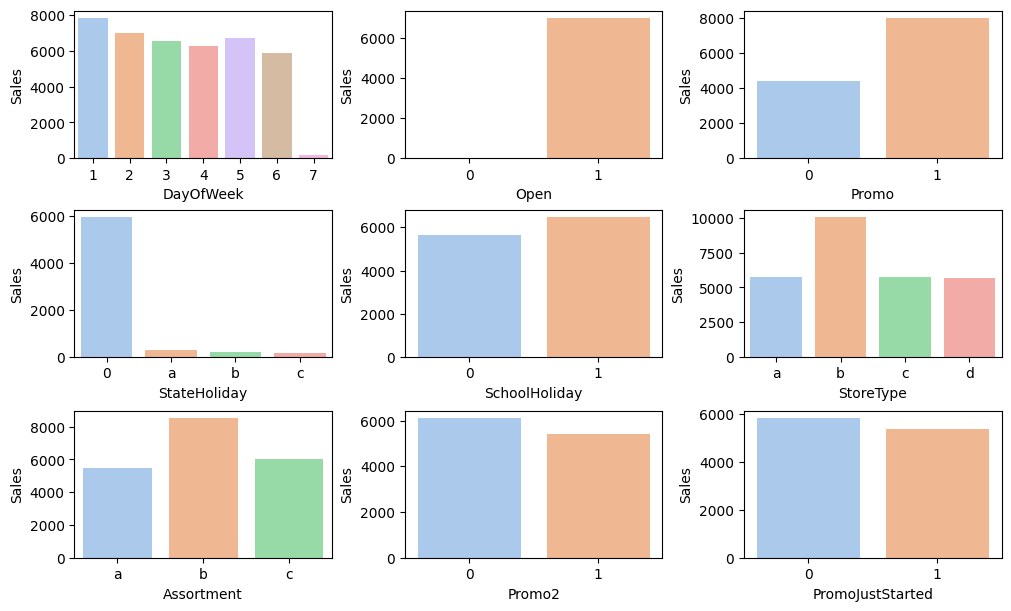

In [67]:
sns.set_palette('pastel')
fig, axes = plt.subplots(3,3,figsize = (10,6), constrained_layout = True)
axes = axes.flatten()
count = len(categorical_features)
for idx in range(count):
    feature = categorical_features[idx]
    df = train_v2.groupby(feature).Sales.mean().to_frame().reset_index()
    sns.barplot(data = df, x = df.columns[0], y = df.columns[1],ax = axes[idx])

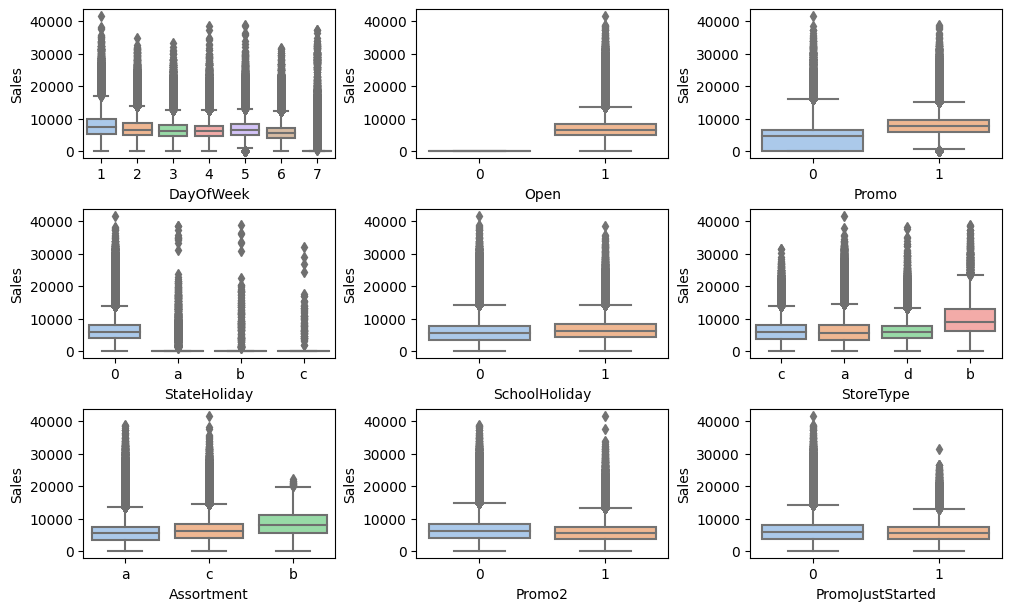

In [68]:
fig, axes = plt.subplots(3,3,figsize = (10,6), constrained_layout = True)
axes = axes.flatten()
count = len(categorical_features)
for idx in range(count):
    feature = categorical_features[idx]
    sns.boxplot(data = train_v2, x = feature, y = 'Sales', ax = axes[idx])

- features that don't seem to have much impact on Sales: SchoolHoliday, PromojustStarted, Promo2
- features that have impact on Sales: DayOfweek(~Open, colinear), Open, Promo, StateHoliday, StoreType, Assortment

In [69]:
# feature pair-correlation
feature_corr = train_v2.loc[:,numerical_features].corr().abs().unstack().sort_values(kind = 'quicksort', ascending = False).reset_index()
feature_corr = feature_corr[feature_corr["level_0"]!=feature_corr["level_1"]]
feature_corr

,level_0,level_1,0
12,NumOfYearSinceCompetitionOpen,CompetitionOpenSinceYear,0.991684
13,CompetitionOpenSinceYear,NumOfYearSinceCompetitionOpen,0.991684
14,Quarter,Month,0.968723
15,Month,Quarter,0.968723
16,Month,WeekOfYear,0.967034
...,...,...,...
139,CompetitionOpenSinceMonth,Month,0.000624
140,WeekOfYear,CompetitionOpenSinceMonth,0.000604
141,CompetitionOpenSinceMonth,WeekOfYear,0.000604
142,Year,CompetitionOpenSinceMonth,0.000121


In [70]:
mask = np.triu(train_v2.loc[:,numerical_features].corr(), k = 0)
mask

array([[ 1.00000000e+00, -1.02861159e-01, -3.09538050e-02,
         8.93062055e-03,  4.05307329e-02,  2.89737519e-02,
        -1.21218014e-03,  3.81789551e-02,  3.60959610e-02,
         4.14039697e-02, -9.77682330e-03, -2.71673209e-02],
       [ 0.00000000e+00,  1.00000000e+00, -6.16242454e-02,
         2.53967363e-02, -5.43835299e-02, -1.09694889e-01,
         7.03275942e-04,  3.57778694e-03,  3.63605925e-03,
         3.46359987e-03, -2.51125630e-02,  9.97681421e-02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        -6.05939877e-02, -3.62509792e-02,  5.03256195e-02,
        -1.21336861e-04, -6.23851488e-04, -6.34457681e-04,
        -6.03702397e-04,  6.00805027e-02, -4.53764583e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00, -7.97836868e-02,  1.21554590e-02,
         7.70590810e-04,  3.91590161e-03,  3.97922271e-03,
         3.79121210e-03, -9.91684344e-01, -1.07376187e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.0000000

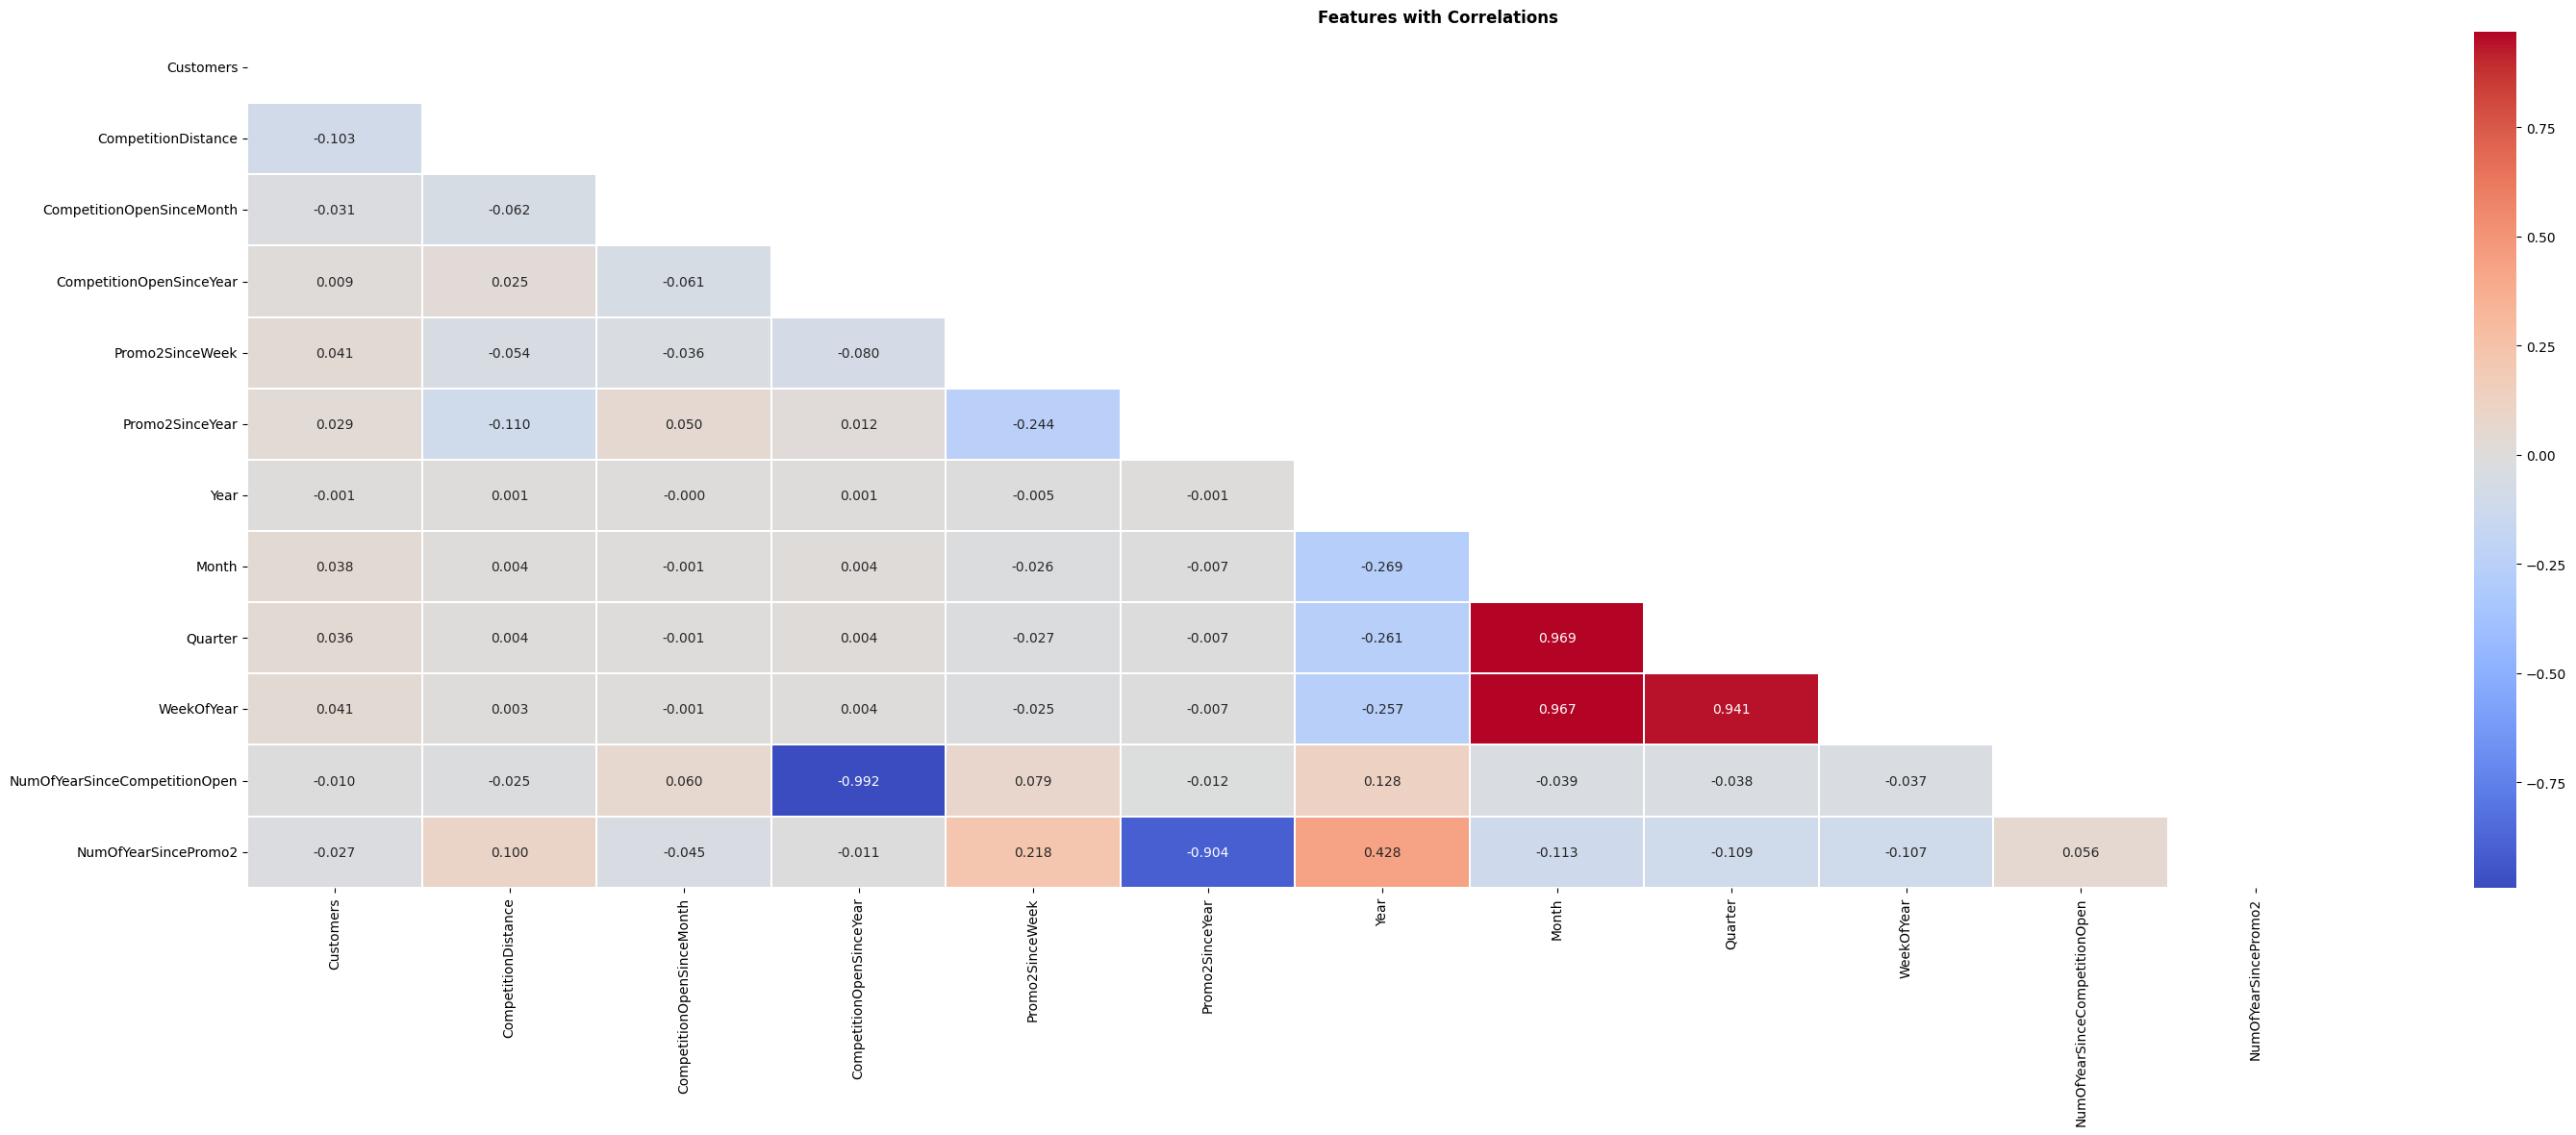

In [71]:
plt.figure(figsize = (30,12))
sns.heatmap(train_v2.loc[:,numerical_features].corr(),
            mask = mask,
            annot = True,
            fmt = '.3f',
            cmap = 'coolwarm',
            linewidth = 0.01,
            cbar = True)

plt.suptitle('Features with Correlations', weight = 'bold')
plt.tight_layout()

- highly correlated features
-- NumOverYearSinceCompetitionOpen vs CompetitionOpenSinceYear, NumberOfYearSincePromo2 vs Promo2SinceYear, Quarter vs Month

In [40]:
train_v2.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Quarter',
       'WeekOfYear', 'PromoInterval_v2', 'PromoJustStarted',
       'NumOfYearSinceCompetitionOpen', 'NumOfYearSincePromo2'],
      dtype='object')

In [41]:
train_v3 = train_v2.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear','PromoInterval','PromoInterval_v2'],axis = 1)
train_v3.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'Promo2', 'Year', 'Month', 'Quarter',
       'WeekOfYear', 'PromoJustStarted', 'NumOfYearSinceCompetitionOpen',
       'NumOfYearSincePromo2'],
      dtype='object')

In [42]:
train_v3['Has_competition_flag'] = [0 if pd.isna(i)==True else 1 for i in train_v3.CompetitionDistance]
train_v3

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionDistance,Promo2,Year,Month,Quarter,WeekOfYear,PromoJustStarted,NumOfYearSinceCompetitionOpen,NumOfYearSincePromo2,Has_competition_flag
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,1270.0,0,2015,7,3,31,0,7.0,NaN,1
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,570.0,1,2015,7,3,31,1,8.0,5.0,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,14130.0,1,2015,7,3,31,1,9.0,4.0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,620.0,0,2015,7,3,31,0,6.0,NaN,1
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,29910.0,0,2015,7,3,31,0,0.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,...,1900.0,1,2013,1,1,1,1,-1.0,0.0,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,...,1880.0,0,2013,1,1,1,0,7.0,NaN,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,...,9260.0,0,2013,1,1,1,0,NaN,NaN,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,...,870.0,0,2013,1,1,1,0,NaN,NaN,1


In [43]:
train_v2.dtypes

Store                                    object
DayOfWeek                                object
Date                             datetime64[ns]
Sales                                     int64
Customers                                 int64
Open                                     object
Promo                                    object
StateHoliday                             object
SchoolHoliday                            object
StoreType                                object
Assortment                               object
CompetitionDistance                     float64
CompetitionOpenSinceMonth               float64
CompetitionOpenSinceYear                float64
Promo2                                   object
Promo2SinceWeek                         float64
Promo2SinceYear                         float64
PromoInterval                            object
Year                                      int64
Month                                     int64
Quarter                                 

In [44]:
train_v3.isna().sum()

Store                                 0
DayOfWeek                             0
Date                                  0
Sales                                 0
Customers                             0
Open                                  0
Promo                                 0
StateHoliday                          0
SchoolHoliday                         0
StoreType                             0
Assortment                            0
CompetitionDistance                2642
Promo2                                0
Year                                  0
Month                                 0
Quarter                               0
WeekOfYear                            0
PromoJustStarted                      0
NumOfYearSinceCompetitionOpen    323348
NumOfYearSincePromo2             508031
Has_competition_flag                  0
dtype: int64

- Imputation is difficult, choose a tree algorithm that can handle null values
- train_v3 has missing values, has a mix of categorical features and numerical features
- train_v3 has outliers

In [45]:
# the goal is to predicted sales up to 6 weeks ahead. 
train_v3['Date+6weeks'] = train_v3.Date + timedelta(weeks = 6)

In [46]:
train_v3

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2,Year,Month,Quarter,WeekOfYear,PromoJustStarted,NumOfYearSinceCompetitionOpen,NumOfYearSincePromo2,Has_competition_flag,Date+6weeks
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,0,2015,7,3,31,0,7.0,NaN,1,2015-09-11
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,1,2015,7,3,31,1,8.0,5.0,1,2015-09-11
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,1,2015,7,3,31,1,9.0,4.0,1,2015-09-11
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,0,2015,7,3,31,0,6.0,NaN,1,2015-09-11
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,0,2015,7,3,31,0,0.0,NaN,1,2015-09-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,...,1,2013,1,1,1,1,-1.0,0.0,1,2013-02-12
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,...,0,2013,1,1,1,0,7.0,NaN,1,2013-02-12
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,...,0,2013,1,1,1,0,NaN,NaN,1,2013-02-12
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,...,0,2013,1,1,1,0,NaN,NaN,1,2013-02-12


In [47]:
train_v4 = pd.merge(train_v3, train_v3[['Store','Date+6weeks','Date','Sales']], left_on = ('Store','Date+6weeks'), right_on = ('Store','Date'), how = 'left')
train_v4

,Store,DayOfWeek,Date_x,Sales_x,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Quarter,WeekOfYear,PromoJustStarted,NumOfYearSinceCompetitionOpen,NumOfYearSincePromo2,Has_competition_flag,Date+6weeks_x,Date+6weeks_y,Date_y,Sales_y
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,3,31,0,7.0,NaN,1,2015-09-11,NaT,NaT,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,3,31,1,8.0,5.0,1,2015-09-11,NaT,NaT,NaN
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,3,31,1,9.0,4.0,1,2015-09-11,NaT,NaT,NaN
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,3,31,0,6.0,NaN,1,2015-09-11,NaT,NaT,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,3,31,0,0.0,NaN,1,2015-09-11,NaT,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,...,1,1,1,-1.0,0.0,1,2013-02-12,2013-03-26,2013-02-12,4891.0
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,...,1,1,0,7.0,NaN,1,2013-02-12,2013-03-26,2013-02-12,8797.0
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,...,1,1,0,NaN,NaN,1,2013-02-12,2013-03-26,2013-02-12,5013.0
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,...,1,1,0,NaN,NaN,1,2013-02-12,2013-03-26,2013-02-12,15364.0


In [48]:
train_v4[(train_v4['Store']==2)&(train_v4.Sales_y.isna()==True)].Date_x.unique()

<DatetimeArray>
['2015-07-31 00:00:00', '2015-07-30 00:00:00', '2015-07-29 00:00:00',
 '2015-07-28 00:00:00', '2015-07-27 00:00:00', '2015-07-26 00:00:00',
 '2015-07-25 00:00:00', '2015-07-24 00:00:00', '2015-07-23 00:00:00',
 '2015-07-22 00:00:00', '2015-07-21 00:00:00', '2015-07-20 00:00:00',
 '2015-07-19 00:00:00', '2015-07-18 00:00:00', '2015-07-17 00:00:00',
 '2015-07-16 00:00:00', '2015-07-15 00:00:00', '2015-07-14 00:00:00',
 '2015-07-13 00:00:00', '2015-07-12 00:00:00', '2015-07-11 00:00:00',
 '2015-07-10 00:00:00', '2015-07-09 00:00:00', '2015-07-08 00:00:00',
 '2015-07-07 00:00:00', '2015-07-06 00:00:00', '2015-07-05 00:00:00',
 '2015-07-04 00:00:00', '2015-07-03 00:00:00', '2015-07-02 00:00:00',
 '2015-07-01 00:00:00', '2015-06-30 00:00:00', '2015-06-29 00:00:00',
 '2015-06-28 00:00:00', '2015-06-27 00:00:00', '2015-06-26 00:00:00',
 '2015-06-25 00:00:00', '2015-06-24 00:00:00', '2015-06-23 00:00:00',
 '2015-06-22 00:00:00', '2015-06-21 00:00:00', '2015-06-20 00:00:00']
Leng

In [50]:
train_v4.isna().sum().to_frame()/train_v4.shape[0]*100

,0
Store,0.000000
DayOfWeek,0.000000
Date_x,0.000000
Sales_x,0.000000
Customers,0.000000
Open,0.000000
Promo,0.000000
StateHoliday,0.000000
SchoolHoliday,0.000000
StoreType,0.000000


- dates from 2015-06-20 to 2015-07-31 have no data for sales in 6 weeks. about 5.3% of the total data. remove null values for now, hopefully the monthly sales pattern from june to july is consistent across different calendar years. could do monthly sales pattern analysis and think about imputation. 

In [51]:
train_v4.tail(3)

,Store,DayOfWeek,Date_x,Sales_x,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Quarter,WeekOfYear,PromoJustStarted,NumOfYearSinceCompetitionOpen,NumOfYearSincePromo2,Has_competition_flag,Date+6weeks_x,Date+6weeks_y,Date_y,Sales_y
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,...,1,1,0,NaN,NaN,1,2013-02-12,2013-03-26,2013-02-12,5013.0
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,...,1,1,0,NaN,NaN,1,2013-02-12,2013-03-26,2013-02-12,15364.0
1017208,1115,2,2013-01-01,0,0,0,0,a,1,d,...,1,1,0,NaN,1.0,1,2013-02-12,2013-03-26,2013-02-12,3039.0


In [52]:
train_v4.rename(columns = {"Date_x":"Date","Sales_x":"Cur_Daily_Sales","Sales_y":"Future_Daily_Sales"}, inplace = True)
train_v4.drop(['Date+6weeks_x','Date+6weeks_y','Date_y'], axis = 1, inplace = True)

In [53]:
train_v4.isna().sum()

Store                                 0
DayOfWeek                             0
Date                                  0
Cur_Daily_Sales                       0
Customers                             0
Open                                  0
Promo                                 0
StateHoliday                          0
SchoolHoliday                         0
StoreType                             0
Assortment                            0
CompetitionDistance                2642
Promo2                                0
Year                                  0
Month                                 0
Quarter                               0
WeekOfYear                            0
PromoJustStarted                      0
NumOfYearSinceCompetitionOpen    323348
NumOfYearSincePromo2             508031
Has_competition_flag                  0
Future_Daily_Sales                54390
dtype: int64

In [54]:
train_v4.dropna(subset='Future_Daily_Sales', inplace = True)

In [55]:
train_v4.shape

(962819, 22)

In [56]:
# regression tree algorithms: decision tree, random forest, gradient boosting trees(xgboots,GBM,lightgbm,catboost), randomized decision forests(rdf), isolation forest, CART 

In [87]:
train_v4.select_dtypes(include=np.number).corrwith(train_v4['Future_Daily_Sales'])

Cur_Daily_Sales                  0.745233
Customers                        0.710233
CompetitionDistance             -0.018352
Year                             0.023937
Month                            0.029034
Quarter                          0.033131
WeekOfYear                       0.038038
NumOfYearSinceCompetitionOpen   -0.010255
NumOfYearSincePromo2             0.031133
Has_competition_flag             0.015982
Future_Daily_Sales               1.000000
dtype: float64

In [81]:
corr_t4 = train_v4.select_dtypes(include=np.number).corr()
corr_t4

,Cur_Daily_Sales,Customers,CompetitionDistance,Year,Month,Quarter,WeekOfYear,NumOfYearSinceCompetitionOpen,NumOfYearSincePromo2,Has_competition_flag,Future_Daily_Sales
Cur_Daily_Sales,1.000000,0.896249,-0.020950,0.021109,0.048968,0.042915,0.052450,-0.011170,0.031336,0.015943,0.745233
Customers,0.896249,1.000000,-0.104366,-0.000239,0.038915,0.035919,0.041891,-0.009525,-0.026008,0.018831,0.710233
CompetitionDistance,-0.020950,-0.104366,1.000000,0.001265,0.003700,0.003624,0.003628,-0.025153,0.100724,NaN,-0.018352
Year,0.021109,-0.000239,0.001265,1.000000,-0.306667,-0.309660,-0.297304,0.124771,0.420233,0.000716,0.023937
Month,0.048968,0.038915,0.003700,-0.306667,1.000000,0.970919,0.967156,-0.042801,-0.126993,0.002094,0.029034
Quarter,0.042915,0.035919,0.003624,-0.309660,0.970919,1.000000,0.943411,-0.043095,-0.128383,0.002051,0.033131
WeekOfYear,0.052450,0.041891,0.003628,-0.297304,0.967156,0.943411,1.000000,-0.041541,-0.123136,0.002054,0.038038
NumOfYearSinceCompetitionOpen,-0.011170,-0.009525,-0.025153,0.124771,-0.042801,-0.043095,-0.041541,1.000000,0.055821,NaN,-0.010255
NumOfYearSincePromo2,0.031336,-0.026008,0.100724,0.420233,-0.126993,-0.128383,-0.123136,0.055821,1.000000,0.026840,0.031133
Has_competition_flag,0.015943,0.018831,NaN,0.000716,0.002094,0.002051,0.002054,NaN,0.026840,1.000000,0.015982


- highly-correlated features: Cur_Daily_Sales&Customers:0.89; Month&Quarter&WeekOfYear
- remove Cur_Daily_Sales since 1) no sales data in test data 2) customers is more correlated with future sales

In [57]:
features = ['DayOfWeek','Customers','Open','Promo','StateHoliday',
           'SchoolHoliday','StoreType','Assortment','CompetitionDistance',
           'NumOfYearSinceCompetitionOpen','NumOfYearSincePromo2','Has_competition_flag',
           'Year','Month','Quarter']
target = ['Future_Daily_Sales']

## Base Model: Linear Regression

In [82]:
train_LR = copy.deepcopy(train_v4)
train_LR.head(3)

,Store,DayOfWeek,Date,Cur_Daily_Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2,Year,Month,Quarter,WeekOfYear,PromoJustStarted,NumOfYearSinceCompetitionOpen,NumOfYearSincePromo2,Has_competition_flag,Future_Daily_Sales
46830,1,5,2015-06-19,4202,487,1,1,0,0,c,...,0,2015,6,2,25,0,7.0,NaN,1,5263.0
46831,2,5,2015-06-19,4926,544,1,1,0,0,a,...,1,2015,6,2,25,0,8.0,5.0,1,6064.0
46832,3,5,2015-06-19,8074,797,1,1,0,0,a,...,1,2015,6,2,25,0,9.0,4.0,1,8314.0


In [92]:
X_LR = train_LR[features]
Y_LR = train_LR[target]

# one-hot encoding
one_hot_encoded_X_LR = pd.get_dummies(X_LR, drop_first = True)

# impute missing values
imputer = SimpleImputer(strategy = 'median')
imputed_X_LR = imputer.fit_transform(one_hot_encoded_X_LR)

X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(imputed_X_LR, Y_LR, test_size = 0.2, random_state = 42)

LR = LinearRegression()
LR.fit(X_train_LR, y_train_LR)

y_test_pred_LR = LR.predict(X_test_LR)

R_squared = r2_score(y_test_LR, y_test_pred_LR)
MSE = mean_squared_error(y_test_LR, y_test_pred_LR)
RMSE = math.sqrt(MSE)
MAE = mean_absolute_error(y_test_LR, y_test_pred_LR)

print(f"R^2 of Linear Regression is {round(R_squared,2)}")
print(f"MSE of Linear Regression is {round(MSE)}")
print(f"RMSE of Linear Regression is {round(RMSE)}")
print(f"MAE of Linear Regression is {round(MAE)}")

R^2 of Linear Regression is 0.64
MSE of Linear Regression is 5463899
RMSE of Linear Regression is 2337
MAE of Linear Regression is 1570


In [94]:
imputed_X_LR_df = pd.DataFrame(imputed_X_LR, columns = one_hot_encoded_X_LR.columns)

vif_x_lr = pd.DataFrame()
vif_x_lr["feature"] = imputed_X_LR_df.columns
vif_x_lr["vif"] = [variance_inflation_factor(imputed_X_LR_df.values, i) for i in range(len(imputed_X_LR_df.columns))]
vif_x_lr

,feature,vif
0,Customers,6.409636
1,CompetitionDistance,1.587336
2,NumOfYearSinceCompetitionOpen,1.925929
3,NumOfYearSincePromo2,3.489630
4,Has_competition_flag,390.291136
5,Year,569.645540
6,Month,70.916983
7,Quarter,96.071082
8,DayOfWeek_2,2.033062
9,DayOfWeek_3,2.043051


#### e1: remove high vif features

In [128]:
high_vif_features = vif_x_lr.sort_values(by = 'vif', ascending = 0).head(5)['feature'].tolist()
high_vif_features

['Year', 'Has_competition_flag', 'Open_1', 'Quarter', 'Month']

In [129]:
imputed_X_LR_df_e1 = imputed_X_LR_df.drop(high_vif_features, axis = 1)

X_train_LR_e1, X_test_LR_e1, y_train_LR_e1, y_test_LR_e1 = train_test_split(imputed_X_LR_df_e1, Y_LR, test_size = 0.2, random_state = 42)
LR.fit(X_train_LR_e1, y_train_LR_e1)

y_test_pred_LR_e1 = LR.predict(X_test_LR_e1)

R_squared_LR_e1 = r2_score(y_test_LR_e1, y_test_pred_LR_e1)
MSE_LR_e1 = mean_squared_error(y_test_LR_e1, y_test_pred_LR_e1)
RMSE_LR_e1 = math.sqrt(MSE_LR_e1)
MAE_LR_e1 = mean_absolute_error(y_test_LR_e1, y_test_pred_LR_e1)

print(f"R^2 of Linear Regression is {round(R_squared_LR_e1,2)}")
print(f"MSE of Linear Regression is {round(MSE_LR_e1)}")
print(f"RMSE of Linear Regression is {round(RMSE_LR_e1)}")
print(f"MAE of Linear Regression is {round(MAE_LR_e1)}")

R^2 of Linear Regression is 0.63
MSE of Linear Regression is 5477559
RMSE of Linear Regression is 2340
MAE of Linear Regression is 1570


- drop top 5 high-vif features does not significantly decrease/increase lr performance. tend to decrease

#### e2: include all features

In [131]:
X_LR_e2 = train_LR.drop(['Store','Date']+target, axis = 1)

# one-hot encoding
one_hot_encoded_X_LR_e2 = pd.get_dummies(X_LR_e2, drop_first = True)

# impute missing values
imputed_X_LR_e2 = imputer.fit_transform(one_hot_encoded_X_LR_e2)

X_train_LR_e2, X_test_LR_e2, y_train_LR_e2, y_test_LR_e2 = train_test_split(imputed_X_LR_e2, Y_LR, test_size = 0.2, random_state = 42)

LR.fit(X_train_LR_e2, y_train_LR_e2)

y_test_pred_LR_e2 = LR.predict(X_test_LR_e2)

R_squared_e2 = r2_score(y_test_LR_e2, y_test_pred_LR_e2)
MSE_e2 = mean_squared_error(y_test_LR_e2, y_test_pred_LR_e2)
RMSE_e2 = math.sqrt(MSE_e2)
MAE_e2 = mean_absolute_error(y_test_LR_e2, y_test_pred_LR_e2)

print(f"R^2 of Linear Regression is {round(R_squared_e2,2)}")
print(f"MSE of Linear Regression is {round(MSE_e2)}")
print(f"RMSE of Linear Regression is {round(RMSE_e2)}")
print(f"MAE of Linear Regression is {round(MAE_e2)}")

R^2 of Linear Regression is 0.66
MSE of Linear Regression is 5028135
RMSE of Linear Regression is 2242
MAE of Linear Regression is 1447


- include all features, with higher collinearity, increase performance even for LR.
- does train_test_split really reflect the validation performance?

#### e3: remove outliers

In [132]:
sales_Q1 = np.percentile(Y_LR, 25)
sales_Q3 = np.percentile(Y_LR, 75)

sales_IQR = sales_Q3 - sales_Q1
lower_bound = sales_Q1 - 1.5*sales_IQR
upper_bound = sales_Q3 + 1.5*sales_IQR

sales_outliers_LR = (train_LR['Future_Daily_Sales'] < lower_bound)|(train_LR['Future_Daily_Sales']>upper_bound)
train_LR_filtered = train_LR[~sales_outliers_LR]

In [133]:
X_LR_removed = train_LR_filtered[features]
Y_LR_removed = train_LR_filtered[target]

# one-hot encoding
one_hot_encoded_X_LR_e3 = pd.get_dummies(X_LR_removed, drop_first = True)

# impute missing values
imputed_X_LR_e3 = imputer.fit_transform(one_hot_encoded_X_LR_e3)

X_train_LR_e3, X_test_LR_e3, y_train_LR_e3, y_test_LR_e3 = train_test_split(imputed_X_LR_e3, Y_LR_removed, test_size = 0.2, random_state = 42)

LR.fit(X_train_LR_e3, y_train_LR_e3)

y_test_pred_LR_e3 = LR.predict(X_test_LR_e3)

R_squared_e3 = r2_score(y_test_LR_e3, y_test_pred_LR_e3)
MSE_e3 = mean_squared_error(y_test_LR_e3, y_test_pred_LR_e3)
RMSE_e3 = math.sqrt(MSE_e3)
MAE_e3 = mean_absolute_error(y_test_LR_e3, y_test_pred_LR_e3)

print(f"R^2 of Linear Regression is {round(R_squared_e3,2)}")
print(f"MSE of Linear Regression is {round(MSE_e3)}")
print(f"RMSE of Linear Regression is {round(RMSE_e3)}")
print(f"MAE of Linear Regression is {round(MAE_e3)}")

R^2 of Linear Regression is 0.61
MSE of Linear Regression is 4447970
RMSE of Linear Regression is 2109
MAE of Linear Regression is 1461


- remove outliers doesn't improve model fit(0.64 -> 0.61), but prediction errors decrease compared to base LR model. 
- maybe because outliers in this dataset not strong enough to impact how the model fit the whole dataset

## Decision Tree Regression

#### 1) supports numerical data only
#### 2) can not handle missing values
#### 3) can not handle categorical values
#### 4) multi-collinearity is not a problem 

In [ ]:
train_DT = copy.deepcopy(train_v4)
train_DT.head(3)

In [ ]:
train_DT.info()

In [ ]:
train_DT.describe(include = np.number).apply(lambda x: round(x,2))

In [ ]:
X_DT = train_DT[features]
Y_DT = train_DT[target]

# one-hot encoding
one_hot_encoded_X_DT = pd.get_dummies(X_DT)

# impute missing values
imputer = SimpleImputer(strategy = 'median')
imputed_X_DT = imputer.fit_transform(one_hot_encoded_X_DT)

X_train_DT, X_test_DT, y_train_DT, y_test_DT = train_test_split(imputed_X_DT, Y_DT, test_size = 0.2, random_state = 42)

regressor_DT = DecisionTreeRegressor(random_state=0)
regressor_DT.fit(X_train_DT, y_train_DT)

y_test_pred_DT = regressor_DT.predict(X_test_DT)

R_squared = r2_score(y_test_DT, y_test_pred_DT)
MSE = mean_squared_error(y_test_DT, y_test_pred_DT)
RMSE = math.sqrt(MSE)
MAE = mean_absolute_error(y_test_DT, y_test_pred_DT)

print(f"R^2 of Decision Tree Regressor is {round(R_squared,2)}")
print(f"MSE of Decision Tree Regressor is {round(MSE)}")
print(f"RMSE of Decision Tree Regressor is {round(RMSE)}")
print(f"MAE of Decision Tree Regressor is {round(MAE)}")

- Decision Tree regressor does not outperforme linear regression in all 4 metrics

## Random Forest

#### 1) bagging reduce overfitting better than decision tree
#### 2) supports numerical features only
#### 3) missing values need to be imputed/removed
#### 4) multi-collinearity is not a problem

In [136]:
train_RF = copy.deepcopy(train_v4)
train_RF.head(3)

,Store,DayOfWeek,Date,Cur_Daily_Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2,Year,Month,Quarter,WeekOfYear,PromoJustStarted,NumOfYearSinceCompetitionOpen,NumOfYearSincePromo2,Has_competition_flag,Future_Daily_Sales
46830,1,5,2015-06-19,4202,487,1,1,0,0,c,...,0,2015,6,2,25,0,7.0,NaN,1,5263.0
46831,2,5,2015-06-19,4926,544,1,1,0,0,a,...,1,2015,6,2,25,0,8.0,5.0,1,6064.0
46832,3,5,2015-06-19,8074,797,1,1,0,0,a,...,1,2015,6,2,25,0,9.0,4.0,1,8314.0


In [ ]:
from sklearn.ensemble import RandomForestRegressor

X_RF = train_RF[features]
Y_RF= train_RF[target]

# one-hot encoding
one_hot_encoded_X_RF = pd.get_dummies(X_RF)

# impute missing values
imputer = SimpleImputer(strategy = 'median')
imputed_X_RF = imputer.fit_transform(one_hot_encoded_X_RF)

X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(imputed_X_RF, np.array(Y_RF).reshape(-1,), test_size = 0.2, random_state = 42)

regressor_RF = RandomForestRegressor(random_state=0)
regressor_RF.fit(X_train_RF, y_train_RF)

y_test_pred_RF = regressor_RF.predict(X_test_RF)

R_squared_RF = r2_score(np.array(y_test_RF), y_test_pred_RF)
MSE_RF = mean_squared_error(y_test_RF, y_test_pred_RF)
RMSE_RF = math.sqrt(MSE_RF)
MAE_RF = mean_absolute_error(y_test_RF, y_test_pred_RF)

print(f"R^2 of Random Forest Regressor is {round(R_squared_RF,2)}")
print(f"MSE of Random Forest Regressor is {round(MSE_RF)}")
print(f"RMSE of Random Forest Regressor is {round(RMSE_RF)}")
print(f"MAE of Random Forest Regressor is {round(MAE_RF)}")

In [ ]:
y_test_pred_RF.shape

- random forest takes a really long time to run.....
- random forest needs y to be in shape (n_samples,), otherwise it will have problem converge. need to reshape y before fitting the model

## XGboost

- can handle categorical columns. need to convert them to category type first
- handles missing values without the need of imputation

In [58]:
train_xgb = copy.deepcopy(train_v4)
train_xgb.head(3)

,Store,DayOfWeek,Date,Cur_Daily_Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2,Year,Month,Quarter,WeekOfYear,PromoJustStarted,NumOfYearSinceCompetitionOpen,NumOfYearSincePromo2,Has_competition_flag,Future_Daily_Sales
46830,1,5,2015-06-19,4202,487,1,1,0,0,c,...,0,2015,6,2,25,0,7.0,NaN,1,5263.0
46831,2,5,2015-06-19,4926,544,1,1,0,0,a,...,1,2015,6,2,25,0,8.0,5.0,1,6064.0
46832,3,5,2015-06-19,8074,797,1,1,0,0,a,...,1,2015,6,2,25,0,9.0,4.0,1,8314.0


In [59]:
X_xgb = train_xgb[features]
Y_xgb = train_xgb[target]

cats = X_xgb.select_dtypes(exclude=np.number).columns.tolist()
X_xgb[cats] = X_xgb[cats].astype('category')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [60]:
X_xgb.dtypes

DayOfWeek                        category
Customers                           int64
Open                             category
Promo                            category
StateHoliday                     category
SchoolHoliday                    category
StoreType                        category
Assortment                       category
CompetitionDistance               float64
NumOfYearSinceCompetitionOpen     float64
NumOfYearSincePromo2              float64
Has_competition_flag                int64
Year                                int64
Month                               int64
Quarter                             int64
dtype: object

In [61]:
def xgboost(feature_data, response_data, ylog = False):
    n = 1000
    params = {"objective":"reg:squarederror",
              "tree_method":"hist"}
    
    X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(feature_data, response_data, test_size = 0.2, random_state = 42)
    if ylog == True:
        y_train_xgb_v2 = np.log(y_train_xgb+2)
        y_test_xgb_v2 = np.log(y_test_xgb+2)
    else:
        y_train_xgb_v2 = y_train_xgb
        y_test_xgb_v2 = y_test_xgb
    
    dtrain_xgb = xgb.DMatrix(X_train_xgb, y_train_xgb_v2, enable_categorical=True)
    dtest_xgb = xgb.DMatrix(X_test_xgb, y_test_xgb_v2, enable_categorical=True)
    
    
    evals = [(dtrain_xgb,"train"),(dtest_xgb,"validation")]
    model = xgb.train(
    params = params,
    dtrain = dtrain_xgb,
    num_boost_round = n,
    evals=evals,
    verbose_eval = 50, #report performance for every 10 rounds
    early_stopping_rounds = 50)
    
    y_preds_xgb = model.predict(dtest_xgb)
    R_squared_xgb = r2_score(y_test_xgb_v2, y_preds_xgb)
    MSE_xgb = mean_squared_error(y_test_xgb_v2, y_preds_xgb)
    RMSE_xgb = math.sqrt(MSE_xgb)
    MAE_xgb = mean_absolute_error(y_test_xgb_v2, y_preds_xgb)
    
    return y_test_xgb, y_test_xgb_v2, y_preds_xgb, R_squared_xgb, MSE_xgb, RMSE_xgb, MAE_xgb

In [92]:
y_test_xgb, y_test_xgb_v2, y_preds_xgb, R_squared_xgb, MSE_xgb, RMSE_xgb, MAE_xgb = xgboost(X_xgb, Y_xgb, False)

print(f"R^2 of XGBoost Regressor is {round(R_squared_xgb,2)}")
print(f"MSE of XGBoost Regressor is {round(MSE_xgb)}")
print(f"RMSE of XGBoost Regressor is {round(RMSE_xgb)}")
print(f"MAE of XGBoost Regressor is {round(MAE_xgb)}")

[0]	train-rmse:5154.08698	validation-rmse:5168.81796
[50]	train-rmse:1822.34329	validation-rmse:1834.23981
[100]	train-rmse:1710.44040	validation-rmse:1729.02408
[150]	train-rmse:1656.55125	validation-rmse:1681.19801
[200]	train-rmse:1608.82402	validation-rmse:1639.42878
[250]	train-rmse:1578.93945	validation-rmse:1615.21823
[300]	train-rmse:1559.66517	validation-rmse:1600.72478
[350]	train-rmse:1541.39351	validation-rmse:1587.82857
[400]	train-rmse:1527.03907	validation-rmse:1578.95794
[450]	train-rmse:1510.59108	validation-rmse:1567.79367
[500]	train-rmse:1498.25550	validation-rmse:1560.90784
[550]	train-rmse:1486.87012	validation-rmse:1554.34109
[600]	train-rmse:1477.93783	validation-rmse:1550.76909
[650]	train-rmse:1468.18387	validation-rmse:1546.16522
[700]	train-rmse:1460.58866	validation-rmse:1543.47121
[750]	train-rmse:1453.53785	validation-rmse:1541.38571
[800]	train-rmse:1447.26012	validation-rmse:1539.25372
[850]	train-rmse:1440.86372	validation-rmse:1537.55114
[900]	train-r

In [137]:
RMSE_xgb/y_test_xgb.mean()

Future_Daily_Sales    0.264029
dtype: float64

- 26% of predicted sales are prediction errors

- xgboost is powerful in handling categorical features and missing data, also the performance is really good. xgboost > random forest > linear regression > decision tree
- [TBD] limitations of xgboost?
- advantages:
    1) performance
    2) scalability: efficient and scalabel training, good for large datasets
    3) customizability: many hyperparameters
    4) handling missing values
    5) handling categorical variables
    6) interpretability, feature importances
    7) regularization
- disadvantages:
    1) computational complexity
    2) overfitting
    3) memory intensive
    4) sensitive to outliers

#### experiment1: sensitive to outliers -> log transformation on y

In [111]:
y_test_xgb_e1, y_test_xgb_v2_e1, y_preds_xgb_e1, R_squared_xgb_e1, MSE_xgb_e1, RMSE_xgb_e1, MAE_xgb_e1 = xgboost(X_xgb, Y_xgb, True)

print(f"R^2 of XGBoost Regressor is {round(R_squared_xgb_e1,2)}")
print(f"MSE of XGBoost Regressor is {MSE_xgb_e1}")
print(f"RMSE of XGBoost Regressor is {RMSE_xgb_e1}")
print(f"MAE of XGBoost Regressor is {MAE_xgb_e1}")

[0]	train-rmse:5.36642	validation-rmse:5.36880
[50]	train-rmse:1.11909	validation-rmse:1.12059
[100]	train-rmse:1.06934	validation-rmse:1.07598
[150]	train-rmse:1.04835	validation-rmse:1.06061
[200]	train-rmse:1.03342	validation-rmse:1.04915
[250]	train-rmse:1.02562	validation-rmse:1.04622
[300]	train-rmse:1.01619	validation-rmse:1.04088
[350]	train-rmse:1.01086	validation-rmse:1.04039
[400]	train-rmse:1.00431	validation-rmse:1.03794
[450]	train-rmse:0.99664	validation-rmse:1.03414
[491]	train-rmse:0.99306	validation-rmse:1.03434
R^2 of XGBoost Regressor is 0.89
MSE of XGBoost Regressor is 1.0698540564232226
RMSE of XGBoost Regressor is 1.0343374963826955
MAE of XGBoost Regressor is 0.40234496827824817


In [138]:
RMSE_xgb_e1/y_test_xgb_v2_e1.mean()*100

Future_Daily_Sales    13.983879
dtype: float64

- about 14% of the predicted sales are erroreous predictions; R^2 improve from 0.84 to 0.89. but hard to compare performance with non-log model. 

In [127]:
# reverse natural logarithm
y_preds_xgb_e1_exp = pd.DataFrame(np.clip(np.exp(y_preds_xgb_e1)-2,0,(np.exp(y_preds_xgb_e1)-2).max())).rename(columns = {0:'predicted_exp'})
R_squared_xgb_e1_exp = r2_score(y_test_xgb_e1, y_preds_xgb_e1_exp)
MSE_xgb_e1_exp = mean_squared_error(y_test_xgb_e1, y_preds_xgb_e1_exp)
RMSE_xgb_e1_exp = math.sqrt(MSE_xgb_e1_exp)
MAE_xgb_e1_exp = mean_absolute_error(y_test_xgb_e1, y_preds_xgb_e1_exp)

print(f"R^2 of XGBoost Regressor is {round(R_squared_xgb_e1_exp,2)}")
print(f"MSE of XGBoost Regressor is {MSE_xgb_e1_exp}")
print(f"RMSE of XGBoost Regressor is {RMSE_xgb_e1_exp}")
print(f"MAE of XGBoost Regressor is {MAE_xgb_e1_exp}")

R^2 of XGBoost Regressor is 0.5
MSE of XGBoost Regressor is 7549377.203787674
RMSE of XGBoost Regressor is 2747.613001095255
MAE of XGBoost Regressor is 1362.3990469595592


- log transformation help improve model performance, but hard to interpret.
- performance metrics dropped significantly after converting back

#### experiment2: sensitive to outliers -> remove outliers

<Axes: >

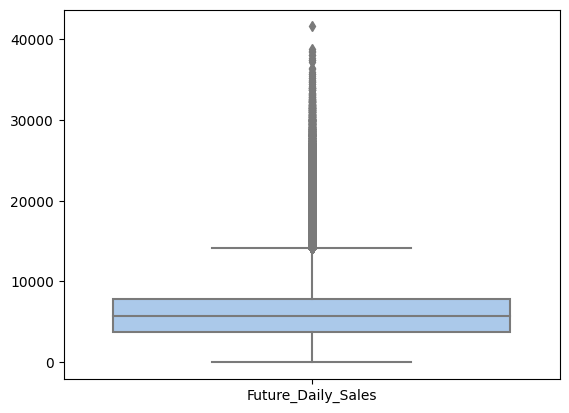

In [156]:
sns.boxplot(Y_xgb)

In [151]:
sales_Q1 = np.percentile(Y_xgb, 25)
sales_Q3 = np.percentile(Y_xgb, 75)

sales_IQR = sales_Q3 - sales_Q1
lower_bound = sales_Q1 - 1.5*sales_IQR
upper_bound = sales_Q3 + 1.5*sales_IQR

sales_outliers = (train_xgb['Future_Daily_Sales'] < lower_bound)|(train_xgb['Future_Daily_Sales']>upper_bound)
train_xgb_filtered = train_xgb[~sales_outliers]

In [153]:
X_xgb_removed = train_xgb_filtered[features]
Y_xgb_removed = train_xgb_filtered[target]

cats = X_xgb_removed.select_dtypes(exclude=np.number).columns.tolist()
X_xgb_removed[cats] = X_xgb_removed[cats].astype('category')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<Axes: >

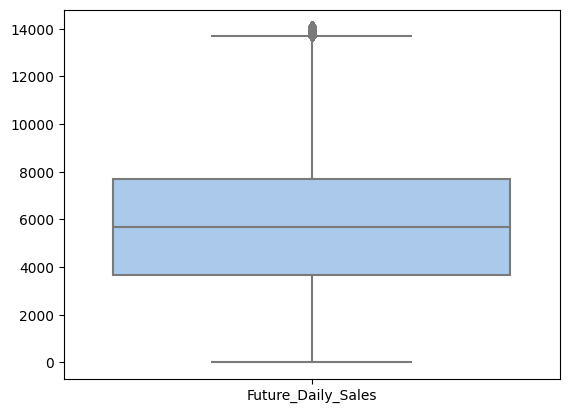

In [154]:
sns.boxplot(Y_xgb_removed)

In [155]:
y_test_xgb_removed, y_test_xgb_v2_removed, y_preds_xgb_removed, R_squared_xgb_removed, MSE_xgb_removed, RMSE_xgb_removed, MAE_xgb_removed = xgboost(X_xgb_removed, Y_xgb_removed, False)

print(f"R^2 of XGBoost Regressor is {round(R_squared_xgb_removed,2)}")
print(f"MSE of XGBoost Regressor is {round(MSE_xgb_removed)}")
print(f"RMSE of XGBoost Regressor is {round(RMSE_xgb_removed)}")
print(f"MAE of XGBoost Regressor is {round(MAE_xgb_removed)}")

[0]	train-rmse:4749.00978	validation-rmse:4755.49750
[50]	train-rmse:1658.62695	validation-rmse:1663.64044
[100]	train-rmse:1553.03741	validation-rmse:1565.43300
[150]	train-rmse:1500.32805	validation-rmse:1518.86860
[200]	train-rmse:1464.57077	validation-rmse:1489.06374
[250]	train-rmse:1426.98161	validation-rmse:1456.03714
[300]	train-rmse:1408.43408	validation-rmse:1442.43547
[350]	train-rmse:1393.91675	validation-rmse:1432.69340
[400]	train-rmse:1381.97718	validation-rmse:1425.55488
[450]	train-rmse:1367.11475	validation-rmse:1415.27498
[500]	train-rmse:1357.21438	validation-rmse:1410.22962
[550]	train-rmse:1347.60697	validation-rmse:1405.13984
[600]	train-rmse:1339.01565	validation-rmse:1401.47506
[650]	train-rmse:1331.59239	validation-rmse:1398.25897
[700]	train-rmse:1324.32875	validation-rmse:1395.69479
[750]	train-rmse:1317.90529	validation-rmse:1393.27058
[800]	train-rmse:1311.35985	validation-rmse:1390.85928
[850]	train-rmse:1305.08330	validation-rmse:1388.68294
[900]	train-r

In [161]:
print(f"R^2 improved by {-(R_squared_xgb-R_squared_xgb_removed)/R_squared_xgb*100}% after removing outliers using IQR")
print(f"MSE improved by {(MSE_xgb-MSE_xgb_removed)/MSE_xgb*100}% after removing outliers using IQR")
print(f"RMSE improved by {(RMSE_xgb-RMSE_xgb_removed)/RMSE_xgb*100}% after removing outliers using IQR")
print(f"MAE improved by {(MAE_xgb-MAE_xgb_removed)/MAE_xgb*100}% after removing outliers using IQR")

R^2 improved by -1.2287748167588888% after removing outliers using IQR
MSE improved by 18.409258672744567% after removing outliers using IQR
RMSE improved by 9.672406581789508% after removing outliers using IQR
MAE improved by 6.9235597682371735% after removing outliers using IQR


- after removing outliers in response value, model fitness doesnt improve, but prediction errors are reduced.
- for xgboost, removing outliers doesnt change the model a lot, but helps improve predictions. 

#### experiment3: sensitive to outliers -> winsorization

In [175]:
Y_xgb

,Future_Daily_Sales
46830,5263.0
46831,6064.0
46832,8314.0
46833,13995.0
46834,4822.0
...,...
1017204,4891.0
1017205,8797.0
1017206,5013.0
1017207,15364.0


In [178]:
from scipy.stats.mstats import winsorize

def winsorization(data, lower_bound, upper_bound):
    
    winsorized_data = winsorize(data, limits = (lower_bound, 1-upper_bound))
    winsorized_data = pd.DataFrame(winsorized_data, columns = ['Future_Daily_Sales'])
    
    return winsorized_data

In [184]:
winsorized_thresh = [0.7,0.8, 0.9, 0.95]

for thresh in winsorized_thresh:
    winsorized_Y_xgb = winsorization(Y_xgb.to_numpy(), 0,thresh)
    y_test_xgb_winsor, y_test_xgb_v2_winsor, y_preds_xgb_winsor, R_squared_xgb_winsor, MSE_xgb_winsor, RMSE_xgb_winsor, MAE_xgb_winsor = xgboost(X_xgb, winsorized_Y_xgb, False)
    
    print(f"with {thresh} winsorization,R^2 of XGBoost Regressor is {round(R_squared_xgb_winsor,2)}")
    print(f"with {thresh} winsorization MSE of XGBoost Regressor is {round(MSE_xgb_winsor)}")
    print(f"with {thresh} winsorization RMSE of XGBoost Regressor is {round(RMSE_xgb_winsor)}")
    print(f"with {thresh} winsorization MAE of XGBoost Regressor is {round(MAE_xgb_winsor)}")
    print("\n")

[0]	train-rmse:4064.26387	validation-rmse:4065.21930
[50]	train-rmse:1167.47446	validation-rmse:1169.19599
[100]	train-rmse:1092.95173	validation-rmse:1099.25332
[150]	train-rmse:1067.72983	validation-rmse:1077.51798
[200]	train-rmse:1039.48214	validation-rmse:1052.56165
[250]	train-rmse:1024.20986	validation-rmse:1040.77584
[300]	train-rmse:1013.02444	validation-rmse:1032.59627
[350]	train-rmse:1002.41639	validation-rmse:1024.77485
[400]	train-rmse:993.24554	validation-rmse:1018.26483
[450]	train-rmse:986.99281	validation-rmse:1015.16328
[500]	train-rmse:979.34571	validation-rmse:1010.23381
[550]	train-rmse:974.09653	validation-rmse:1008.27792
[600]	train-rmse:968.88152	validation-rmse:1006.37651
[650]	train-rmse:963.18126	validation-rmse:1003.24579
[700]	train-rmse:958.29002	validation-rmse:1000.74799
[750]	train-rmse:954.29061	validation-rmse:999.46158
[800]	train-rmse:950.53858	validation-rmse:998.71614
[850]	train-rmse:947.10944	validation-rmse:997.86724
[900]	train-rmse:943.39984

- winsorization did help with improve model performance, but if outliers reflect natural variability in sales data, outliers should be left in the dataset untouched.

#### experiment4: sensitive to outliers -> advanced algorithm to remove outliers

In [25]:
# one-hot encoding
one_hot_encoded_train_xgb = pd.get_dummies(train_xgb[features+target])

# impute missing values
imputer = SimpleImputer(strategy = 'median')
imputed_train_xgb = imputer.fit_transform(one_hot_encoded_train_xgb)

In [ ]:
# Local Outlier Factor
# from sklearn.neighbors import LocalOutlierFactor

# lof = LocalOutlierFactor(n_neighbors=100)
# outliers = lof.fit_predict(imputed_train_xgb)

- LOF/Isolation Forest doesnt support categorical data/null values, which contrasts the intention of choosing XGBoost.
- LOF takes so long to run, cant converge and kernel just died, try isolation forest
- isolation forest is way faster than LOF

In [29]:
# isolation forest
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.1)
outliers_if = iso.fit_predict(imputed_train_xgb)
train_xgb['outlier_if'] = outliers_if

In [46]:
print(f"There are a total {train_xgb[train_xgb.outlier_if==-1].shape[0]} outliers identified by the isolation forest algorithm")

There are a total 96282 outliers identified by the isolation forest algorithm


In [44]:
filtered_train_xgb = train_xgb[train_xgb.outlier_if==1]
filtered_X_xgb = filtered_train_xgb[features]
filtered_Y_xgb = filtered_train_xgb[target]

filtered_cats = filtered_X_xgb.select_dtypes(exclude=np.number).columns.tolist()
filtered_X_xgb[filtered_cats] = filtered_X_xgb[filtered_cats].astype('category')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [45]:
y_test_xgb_if_filtered, y_test_xgb_v2_if_filtered, y_preds_xgb_if_filtered, R_squared_xgb_if_filtered, MSE_xgb_if_filtered, RMSE_xgb_if_filtered, MAE_xgb_if_filtered = xgboost(filtered_X_xgb, filtered_Y_xgb, False)

print(f"R^2 of XGBoost Regressor is {round(R_squared_xgb_if_filtered,2)}")
print(f"MSE of XGBoost Regressor is {round(MSE_xgb_if_filtered)}")
print(f"RMSE of XGBoost Regressor is {round(RMSE_xgb_if_filtered)}")
print(f"MAE of XGBoost Regressor is {round(MAE_xgb_if_filtered)}")

[0]	train-rmse:5003.46267	validation-rmse:5004.99770
[50]	train-rmse:1755.51139	validation-rmse:1771.63761
[100]	train-rmse:1656.87327	validation-rmse:1680.00683
[150]	train-rmse:1598.81761	validation-rmse:1629.81252
[200]	train-rmse:1564.20552	validation-rmse:1602.22986
[250]	train-rmse:1533.35281	validation-rmse:1578.38454
[300]	train-rmse:1515.93917	validation-rmse:1568.48248
[350]	train-rmse:1500.75261	validation-rmse:1560.67881
[400]	train-rmse:1486.89457	validation-rmse:1553.97299
[450]	train-rmse:1475.11403	validation-rmse:1548.48184
[500]	train-rmse:1462.80610	validation-rmse:1541.21919
[550]	train-rmse:1455.08216	validation-rmse:1539.58033
[600]	train-rmse:1445.68704	validation-rmse:1536.80156
[650]	train-rmse:1437.93499	validation-rmse:1535.39263
[700]	train-rmse:1430.54845	validation-rmse:1534.05137
[750]	train-rmse:1423.63940	validation-rmse:1532.61299
[800]	train-rmse:1416.42865	validation-rmse:1531.65541
[850]	train-rmse:1409.61817	validation-rmse:1530.43929
[900]	train-r

- either the parameters of the IF algorithm is not good enough, either the effort to remove outliers for xgboost is not effective.
- outlier detection algorithm adds more hyperparameters to tune.

In [ ]:
# DBSCAN: density based clustering technique
from sklearn.cluster import DBSCAN

# dbscan = DBSCAN()
# outliers_db = dbscan.fit_predict(imputed_train_xgb)

- dbscan also requires realllllly long time to train, never converge, kernel dies

#### experiment5: XGboost is immune to multi-collinearity

In [64]:
X_xgb.dtypes

DayOfWeek                        category
Customers                           int64
Open                             category
Promo                            category
StateHoliday                     category
SchoolHoliday                    category
StoreType                        category
Assortment                       category
CompetitionDistance               float64
NumOfYearSinceCompetitionOpen     float64
NumOfYearSincePromo2              float64
Has_competition_flag                int64
Year                                int64
Month                               int64
Quarter                             int64
dtype: object

In [81]:
# calculate VIF for each feature
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_xgb_dummies = pd.get_dummies(X_xgb, dtype = int, drop_first = True)
# impute missing values
imputer = SimpleImputer(strategy = 'median')
X_xgb_dummies = pd.DataFrame(imputer.fit_transform(X_xgb_dummies), columns = X_xgb_dummies.columns)

vif_x_xgb = pd.DataFrame()
vif_x_xgb["feature"] = X_xgb_dummies.columns
vif_x_xgb["vif"] = [variance_inflation_factor(X_xgb_dummies.values, i) for i in range(len(X_xgb_dummies.columns))]
vif_x_xgb

,feature,vif
0,Customers,6.409636
1,CompetitionDistance,1.587336
2,NumOfYearSinceCompetitionOpen,1.925929
3,NumOfYearSincePromo2,3.489630
4,Has_competition_flag,390.291136
5,Year,569.645540
6,Month,70.916983
7,Quarter,96.071082
8,DayOfWeek_2,2.033062
9,DayOfWeek_3,2.043051


- if vif is inf, probably bc of perfect collinearity, can be resolved by setting drop_first = True
- vif is designed for numerical variables, not very good for categorical variables

- highly correlated features: NumOverYearSinceCompetitionOpen vs CompetitionOpenSinceYear, NumberOfYearSincePromo2 vs Promo2SinceYear, Quarter vs Month

In [93]:
X_xgb.columns

Index(['DayOfWeek', 'Customers', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'NumOfYearSinceCompetitionOpen', 'NumOfYearSincePromo2',
       'Has_competition_flag', 'Year', 'Month', 'Quarter'],
      dtype='object')

In [100]:
train_xgb.columns

Index(['Store', 'DayOfWeek', 'Date', 'Cur_Daily_Sales', 'Customers', 'Open',
       'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'Promo2', 'Year', 'Month', 'Quarter',
       'WeekOfYear', 'PromoJustStarted', 'NumOfYearSinceCompetitionOpen',
       'NumOfYearSincePromo2', 'Has_competition_flag', 'Future_Daily_Sales'],
      dtype='object')

In [94]:
# remove NumOverYearSinceCompetitionOpen
X_xgb_v1 = X_xgb.drop('NumOfYearSinceCompetitionOpen', axis = 1)
X_xgb_v1

,DayOfWeek,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,NumOfYearSincePromo2,Has_competition_flag,Year,Month,Quarter
46830,5,487,1,1,0,0,c,a,1270.0,NaN,1,2015,6,2
46831,5,544,1,1,0,0,a,a,570.0,5.0,1,2015,6,2
46832,5,797,1,1,0,0,a,a,14130.0,4.0,1,2015,6,2
46833,5,1281,1,1,0,0,c,c,620.0,NaN,1,2015,6,2
46834,5,610,1,1,0,0,a,a,29910.0,NaN,1,2015,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,2,0,0,0,a,1,a,a,1900.0,0.0,1,2013,1,1
1017205,2,0,0,0,a,1,c,c,1880.0,NaN,1,2013,1,1
1017206,2,0,0,0,a,1,a,c,9260.0,NaN,1,2013,1,1
1017207,2,0,0,0,a,1,a,c,870.0,NaN,1,2013,1,1


In [95]:
y_test_xgb_e5_v1, y_test_xgb_v2_e5_v1, y_preds_xgb_e5_v1, R_squared_xgb_e5_v1, MSE_xgb_e5_v1, RMSE_xgb_e5_v1, MAE_xgb_e5_v1 = xgboost(X_xgb_v1, Y_xgb, False)

print(f"R^2 of XGBoost Regressor is {round(R_squared_xgb_e5_v1,2)}")
print(f"MSE of XGBoost Regressor is {round(MSE_xgb_e5_v1)}")
print(f"RMSE of XGBoost Regressor is {round(RMSE_xgb_e5_v1)}")
print(f"MAE of XGBoost Regressor is {round(MAE_xgb_e5_v1)}")

[0]	train-rmse:5154.09415	validation-rmse:5168.78565
[50]	train-rmse:1826.59684	validation-rmse:1839.05423
[100]	train-rmse:1741.22029	validation-rmse:1758.42074
[150]	train-rmse:1668.92371	validation-rmse:1692.79500
[200]	train-rmse:1623.00402	validation-rmse:1653.81255
[250]	train-rmse:1597.82794	validation-rmse:1633.41310
[300]	train-rmse:1576.16057	validation-rmse:1616.38069
[350]	train-rmse:1557.55746	validation-rmse:1601.77381
[400]	train-rmse:1543.69190	validation-rmse:1592.95074
[450]	train-rmse:1530.98962	validation-rmse:1585.70259
[500]	train-rmse:1518.88573	validation-rmse:1578.60318
[550]	train-rmse:1506.95616	validation-rmse:1571.31687
[600]	train-rmse:1498.51894	validation-rmse:1568.27644
[650]	train-rmse:1490.14748	validation-rmse:1564.68031
[700]	train-rmse:1482.12548	validation-rmse:1562.04876
[750]	train-rmse:1475.13460	validation-rmse:1559.56265
[800]	train-rmse:1468.64459	validation-rmse:1558.04601
[850]	train-rmse:1462.41245	validation-rmse:1555.93396
[900]	train-r

In [98]:
# remove NumOverYearSinceCompetitionOpen+Month
X_xgb_v2 = X_xgb.drop(['NumOfYearSinceCompetitionOpen','Month'], axis = 1)
X_xgb_v2

y_test_xgb_e5_v2, y_test_xgb_v2_e5_v2, y_preds_xgb_e5_v2, R_squared_xgb_e5_v2, MSE_xgb_e5_v2, RMSE_xgb_e5_v2, MAE_xgb_e5_v2 = xgboost(X_xgb_v2, Y_xgb, False)

print(f"R^2 of XGBoost Regressor is {round(R_squared_xgb_e5_v2,2)}")
print(f"MSE of XGBoost Regressor is {round(MSE_xgb_e5_v2)}")
print(f"RMSE of XGBoost Regressor is {round(RMSE_xgb_e5_v2)}")
print(f"MAE of XGBoost Regressor is {round(MAE_xgb_e5_v2)}")

[0]	train-rmse:5154.16491	validation-rmse:5168.76022
[50]	train-rmse:2034.46286	validation-rmse:2047.71785
[100]	train-rmse:1967.94305	validation-rmse:1986.04268
[150]	train-rmse:1926.41677	validation-rmse:1951.62458
[200]	train-rmse:1895.49319	validation-rmse:1927.83054
[250]	train-rmse:1873.53973	validation-rmse:1911.74665
[300]	train-rmse:1858.72581	validation-rmse:1904.34754
[350]	train-rmse:1843.05600	validation-rmse:1894.40501
[400]	train-rmse:1831.26996	validation-rmse:1889.45363
[450]	train-rmse:1820.91474	validation-rmse:1884.36314
[500]	train-rmse:1811.82610	validation-rmse:1880.73151
[550]	train-rmse:1803.77755	validation-rmse:1878.14148
[600]	train-rmse:1795.83899	validation-rmse:1876.07460
[650]	train-rmse:1787.84113	validation-rmse:1873.75428
[700]	train-rmse:1780.84182	validation-rmse:1872.21170
[750]	train-rmse:1774.10564	validation-rmse:1870.34639
[800]	train-rmse:1768.18144	validation-rmse:1869.47507
[850]	train-rmse:1762.41399	validation-rmse:1868.91762
[900]	train-r

In [99]:
# remove NumOverYearSinceCompetitionOpen+Quarter
X_xgb_v3 = X_xgb.drop(['NumOfYearSinceCompetitionOpen','Quarter'], axis = 1)
X_xgb_v3

y_test_xgb_e5_v3, y_test_xgb_v2_e5_v3, y_preds_xgb_e5_v3, R_squared_xgb_e5_v3, MSE_xgb_e5_v3, RMSE_xgb_e5_v3, MAE_xgb_e5_v3 = xgboost(X_xgb_v3, Y_xgb, False)

print(f"R^2 of XGBoost Regressor is {round(R_squared_xgb_e5_v3,2)}")
print(f"MSE of XGBoost Regressor is {round(MSE_xgb_e5_v3)}")
print(f"RMSE of XGBoost Regressor is {round(RMSE_xgb_e5_v3)}")
print(f"MAE of XGBoost Regressor is {round(MAE_xgb_e5_v3)}")

[0]	train-rmse:5154.09415	validation-rmse:5168.78565
[50]	train-rmse:1826.59684	validation-rmse:1839.05423
[100]	train-rmse:1741.22029	validation-rmse:1758.42074
[150]	train-rmse:1668.92371	validation-rmse:1692.79500
[200]	train-rmse:1623.00402	validation-rmse:1653.81255
[250]	train-rmse:1597.82794	validation-rmse:1633.41310
[300]	train-rmse:1576.16057	validation-rmse:1616.38069
[350]	train-rmse:1557.55746	validation-rmse:1601.77381
[400]	train-rmse:1543.69190	validation-rmse:1592.95074
[450]	train-rmse:1530.98962	validation-rmse:1585.70259
[500]	train-rmse:1518.88573	validation-rmse:1578.60318
[550]	train-rmse:1506.95616	validation-rmse:1571.31687
[600]	train-rmse:1498.51894	validation-rmse:1568.27644
[650]	train-rmse:1490.14748	validation-rmse:1564.68031
[700]	train-rmse:1482.12548	validation-rmse:1562.04876
[750]	train-rmse:1475.13460	validation-rmse:1559.56265
[800]	train-rmse:1468.64459	validation-rmse:1558.04601
[850]	train-rmse:1462.41245	validation-rmse:1555.93396
[900]	train-r

In [110]:
# include all features
X_xgb_v4 = train_xgb.drop(['Store','Date']+target, axis = 1)
cats_v4 = X_xgb_v4.select_dtypes(exclude=np.number).columns.tolist()
X_xgb_v4[cats_v4] = X_xgb_v4[cats_v4].astype('category')

y_test_xgb_e5_v4, y_test_xgb_v2_e5_v4, y_preds_xgb_e5_v4, R_squared_xgb_e5_v4, MSE_xgb_e5_v4, RMSE_xgb_e5_v4, MAE_xgb_e5_v4 = xgboost(X_xgb_v4, Y_xgb, False)

print(f"R^2 of XGBoost Regressor is {round(R_squared_xgb_e5_v4,2)}")
print(f"MSE of XGBoost Regressor is {round(MSE_xgb_e5_v4)}")
print(f"RMSE of XGBoost Regressor is {round(RMSE_xgb_e5_v4)}")
print(f"MAE of XGBoost Regressor is {round(MAE_xgb_e5_v4)}")

[0]	train-rmse:5130.03093	validation-rmse:5145.97052
[50]	train-rmse:1440.62694	validation-rmse:1464.73914
[100]	train-rmse:1262.36618	validation-rmse:1295.45995
[150]	train-rmse:1208.79545	validation-rmse:1251.56410
[200]	train-rmse:1150.32301	validation-rmse:1200.25873
[250]	train-rmse:1097.30168	validation-rmse:1154.87103
[300]	train-rmse:1066.00964	validation-rmse:1128.93381
[350]	train-rmse:1042.72989	validation-rmse:1111.47035
[400]	train-rmse:1017.61445	validation-rmse:1091.58565
[450]	train-rmse:997.46406	validation-rmse:1075.89584
[500]	train-rmse:982.92818	validation-rmse:1066.20438
[550]	train-rmse:967.20310	validation-rmse:1054.68422
[600]	train-rmse:952.99594	validation-rmse:1045.41908
[650]	train-rmse:939.19703	validation-rmse:1036.33079
[700]	train-rmse:929.67128	validation-rmse:1031.60645
[750]	train-rmse:919.83812	validation-rmse:1026.05702
[800]	train-rmse:909.93557	validation-rmse:1019.52744
[850]	train-rmse:901.17314	validation-rmse:1014.43382
[900]	train-rmse:892.7

-?????remove highly-correlated features and peformance improve like that????????????? no wonder people just throw all features into xgboost.

## LightGBM

- do not support categorical featrues
- can handle missing values
- faster training with GOSS(gradient based on side sampling) + exclusive feature bundling(EFB)
- low memory utiilization
- solve overfitting better when working with smaller dataset

In [134]:
train_lgbm = copy.deepcopy(train_v4)
train_lgbm.head(3)

,Store,DayOfWeek,Date,Cur_Daily_Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2,Year,Month,Quarter,WeekOfYear,PromoJustStarted,NumOfYearSinceCompetitionOpen,NumOfYearSincePromo2,Has_competition_flag,Future_Daily_Sales
46830,1,5,2015-06-19,4202,487,1,1,0,0,c,...,0,2015,6,2,25,0,7.0,NaN,1,5263.0
46831,2,5,2015-06-19,4926,544,1,1,0,0,a,...,1,2015,6,2,25,0,8.0,5.0,1,6064.0
46832,3,5,2015-06-19,8074,797,1,1,0,0,a,...,1,2015,6,2,25,0,9.0,4.0,1,8314.0


In [135]:
X_lgbm = train_lgbm[features]
Y_lgbm = train_lgbm[target]

# one-hot encoding
one_hot_encoded_X_lgbm = pd.get_dummies(X_lgbm)

X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(one_hot_encoded_X_lgbm, Y_lgbm, test_size = 0.2, random_state = 42)
model = lgb.LGBMRegressor()
model.fit(X_train_lgbm,y_train_lgbm)

y_preds_lgbm = model.predict(X_test_lgbm)

R_squared_lgbm = r2_score(y_test_lgbm, y_preds_lgbm)
MSE_lgbm = mean_squared_error(y_test_lgbm, y_preds_lgbm)
RMSE_lgbm = math.sqrt(MSE_lgbm)
MAE_lgbm = mean_absolute_error(y_test_lgbm, y_preds_lgbm)

print(f"R^2 of XGBoost Regressor is {round(R_squared_lgbm,2)}")
print(f"MSE of XGBoost Regressor is {round(MSE_lgbm)}")
print(f"RMSE of XGBoost Regressor is {round(RMSE_lgbm)}")
print(f"MAE of XGBoost Regressor is {round(MAE_lgbm)}")

R^2 of XGBoost Regressor is 0.76
MSE of XGBoost Regressor is 3640708
RMSE of XGBoost Regressor is 1908
MAE of XGBoost Regressor is 1246


- lightgbm is fast
- performance is no better than xgboost, smiliar to random forest

In [ ]:
# plot the lgbm model
import matplotlib.pyplot as plt
import seaborn as sns

## Catboost

- handles well mix of categorical and numerical features
- automatically handles missing values
- fast training
- optimized hyperparameters

In [ ]:
train_ctb = copy.deepcopy(train_v4)
train_ctb.head(3)

In [ ]:
X_ctb = train_ctb[features]
Y_ctb = train_ctb[target]

# category features
cats = X_ctb.select_dtypes(exclude=np.number).columns.tolist()
X_ctb[cats] = X_ctb[cats].astype('category')

X_train_ctb, X_test_ctb, y_train_ctb, y_test_ctb = train_test_split(X_ctb, Y_ctb, test_size = 0.2, random_state = 42)
Dtrain_ctb = cb.Pool(X_train_ctb,y_train_ctb, cat_features = cats)
Dtest_ctb = cb.Pool(X_test_ctb,y_test_ctb, cat_features = cats)

reg_cat = cb.CatBoostRegressor(loss_function='RMSE')
reg_cat.fit(Dtrain_ctb)

In [ ]:
y_preds_ctb = reg_cat.predict(X_test_ctb)

R_squared_ctb = r2_score(y_test_ctb, y_preds_ctb)
MSE_ctb = mean_squared_error(y_test_ctb, y_preds_ctb)
RMSE_ctb = math.sqrt(MSE_ctb)
MAE_ctb = mean_absolute_error(y_test_ctb, y_preds_ctb)

print(f"R^2 of Catboost Regressor is {round(R_squared_ctb,2)}")
print(f"MSE of Catboost Regressor is {round(MSE_ctb)}")
print(f"RMSE of Catboost Regressor is {round(RMSE_ctb)}")
print(f"MAE of Catboost Regressor is {round(MAE_ctb)}")


- takes a long time to run
- performance is worse than xgboost, but better than lightgbm, random forest
- imputation with median causes performance deterioration. r^2 from 0.8 to 0.68

In [ ]:
# shap explain the output of any machine learning model

sorted_feature_importance = reg_cat.feature_importances_.argsort()

explainer = shap.TreeExplainer(reg_cat)
shap_values = explainer.shap_values(X_test_ctb)

shap.summary_plot(shap_values, X_test_ctb, feature_names = X_test_ctb.columns.tolist())

- how to interpret this?

In [ ]:
train_v2.Date[0].year

In [ ]:
 train_v2.Date.apply(lambda x:x.quarter)